In [1]:
%matplotlib inline
import json
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats import multitest
from util import read_df, filter_spam, effect_size, phi_coeff
import community as c

In [2]:
mpl.rc('font', size=9)

## The Data

Let's start by loading up all our data. We primarily use data on GG from Aug-Dec 2014, along with data from an assortment of other storms identified by Lamba et al.

In [36]:
storms = pd.DataFrame([
    ('hashtag', 'whyimvotingukip', '2014-05-20'),
    ('hashtag', 'muslimrage', '2012-09-17'),
    ('hashtag', 'CancelColbert', '2014-03-27'),
    ('hashtag', 'myNYPD', '2014-04-22'),
    ('hashtag', 'AskThicke', '2014-06-30'),
    ('user', '14075928', '2013-02-24'), # @TheOnion
    ('user', '56377143', '2014-06-29'), # @KLM
    ('user', '103065157', '2014-03-05'), # @David_Cameron
    ('screen_name', 'celebboutique', '2012-07-20'), # screen name is used here because a new account uses that name
    ('user', '109387470', '2014-06-29'), # @GaelGarciaB
    ('hashtag', 'AskJPM', '2013-11-06'),
    ('hashtag', 'McDStories', '2012-01-18'),
    ('hashtag', 'AskBG', '2013-10-17'),
    ('hashtag', 'VogueArticles', '2014-09-10'),
    ('user', '188001904', '2014-06-25'), # @fafsa
    ('user', '1226598505', '2013-12-06'), # @SpaghettiOs
], columns=['type', 'name', 'date'])
storms

type             name        date
0       hashtag  whyimvotingukip  2014-05-20
1       hashtag       muslimrage  2012-09-17
2       hashtag    CancelColbert  2014-03-27
3       hashtag           myNYPD  2014-04-22
4       hashtag        AskThicke  2014-06-30
5          user         14075928  2013-02-24
6          user         56377143  2014-06-29
7          user        103065157  2014-03-05
8   screen_name    celebboutique  2012-07-20
9          user        109387470  2014-06-29
10      hashtag           AskJPM  2013-11-06
11      hashtag       McDStories  2012-01-18
12      hashtag            AskBG  2013-10-17
13      hashtag    VogueArticles  2014-09-10
14         user        188001904  2014-06-25
15         user       1226598505  2013-12-06

In [37]:
storm_dfs = {}

In [38]:
for idx, storm in storms.iterrows():
    if idx in storm_dfs:
        continue # skip things we've already loaded
    print(storm['name'])
    storm_dfs[idx] = c.data_for(*storm.values)

whyimvotingukip
muslimrage
CancelColbert
myNYPD
AskThicke
14075928
56377143
103065157
celebboutique
109387470
AskJPM
McDStories
AskBG
VogueArticles
188001904
1226598505


In [3]:
gg_df = pd.read_pickle('gg-users_2014-08_2014-12.pkl.gz') # preprocessed because it takes *ages* to load otherwise

In [39]:
rand_df = filter_spam(read_df(['random-users-tweets-augsep.json']))

0.49681605728977196 2.164827109266943


In [57]:
def hashtag_df(df, htag):
    return df[df['entities.hashtags'].map(lambda hashtags: any(ht['text'].lower() == htag.lower() for ht in hashtags))]

In [153]:
def mentioned_df(df, user):
    return df[df['entities.user_mentions'].map(lambda mentions: any(m['id_str'] == user for m in mentions))]

In [145]:
def mention_screen_df(df, user):
    return df[df['entities.user_mentions'].map(lambda mentions: any(m['screen_name'].lower() == user.lower() for m in mentions))]

In [146]:
def relevant_df(df, key):
    storm = storms.loc[key]
    if storm['type'] == 'hashtag':
        return hashtag_df(df, storm['name'])
    elif storm['type'] == 'user':
        return mentioned_df(df, storm['name'])
    elif storm['type'] == 'screen_name':
        return mention_screen_df(df, storm['name'])

In [43]:
def format_storm_name(type, name):
    users = {
        '14075928': 'TheOnion',
        '56377143': 'KLM',
        '103065157': 'David_Cameron',
        '109387470': 'GaelGarciaB',
        '188001904': 'fafsa',
        '1226598505': 'SpaghettiOs'
    }
    
    if type == 'hashtag':
        return '#{}'.format(name)
    elif type == 'user':
        return '@{}'.format(users[name])
    elif type == 'screen_name':
        return '@{}'.format(name)

In [616]:
out_rows = []
for idx, storm in storms.iterrows():
    out_rows += [
        {
            'Storm': format_storm_name(storm['type'], storm['name']),
            'Event Date': pd.to_datetime(storm['date']).strftime('%-d %b %Y'),
            'First Tweet': storm_dfs[idx].index[0].strftime('%-d %b %Y'),
            'Last Tweet': storm_dfs[idx].index[-1].strftime('%-d %b %Y'),
            '# Tweets': len(storm_dfs[idx]),
            '# Relevant Tweets': len(relevant_df(storm_dfs[idx], idx)),
            '# Users': storm_dfs[idx]['user.id'].nunique(),
        }
    ]
    
out_rows += [
    {
            'Storm': '#GamerGate',
            'Event Date': '28 Aug 2014',
            'First Tweet': gg_df.index[0].strftime('%-d %b %Y'),
            'Last Tweet': gg_df.index[-1].strftime('%-d %b %Y'),
            '# Tweets': len(gg_df),
            '# Relevant Tweets': len(hashtag_df(gg_df, 'gamergate')),
            '# Users': gg_df['user.id'].nunique(),
    },    
    {
            'Storm': '#GamerGate (2015)',
            'Event Date': '-',
            'First Tweet': gg15.index[0].strftime('%-d %b %Y'),
            'Last Tweet': gg15.index[-1].strftime('%-d %b %Y'),
            '# Tweets': len(gg15),
            '# Relevant Tweets': len(hashtag_df(gg15, 'gamergate')),
            '# Users': gg15['user.id'].nunique(),
    },
    {
            'Storm': 'Random',
            'Event Date': '-',
            'First Tweet': rand_df.index[0].strftime('%-d %b %Y'),
            'Last Tweet': rand_df.index[-1].strftime('%-d %b %Y'),
            '# Tweets': len(rand_df),
            '# Relevant Tweets': 0,
            '# Users': rand_df['user.id'].nunique(),
    },
]
    
print(pd.DataFrame(out_rows).set_index('Storm').sort_values('# Relevant Tweets', ascending=False)[['Event Date', 'First Tweet', 'Last Tweet', '# Tweets', '# Relevant Tweets', '# Users']].to_latex())

\begin{tabular}{llllrrr}
\toprule
{} &   Event Date &  First Tweet &   Last Tweet &  \# Tweets &  \# Relevant Tweets &  \# Users \\
Storm             &              &              &              &           &                    &          \\
\midrule
\#GamerGate        &  28 Aug 2014 &   1 Aug 2014 &   1 Jan 2015 &    565826 &              69676 &    14984 \\
\#GamerGate (2015) &            - &   1 Aug 2015 &   1 Oct 2015 &     61378 &               7494 &     2615 \\
\#whyimvotingukip  &  20 May 2014 &   6 May 2014 &  30 Jun 2014 &     44590 &               4263 &     4125 \\
@TheOnion         &  24 Feb 2013 &  10 Feb 2013 &   6 Apr 2013 &     40870 &               3557 &     4453 \\
@David\_Cameron    &   5 Mar 2014 &  19 Feb 2014 &  15 Apr 2014 &     57830 &               2898 &     3468 \\
\#myNYPD           &  22 Apr 2014 &   1 Apr 2014 &   1 Jun 2014 &     50039 &               1850 &     1749 \\
\#muslimrage       &  17 Sep 2012 &   3 Sep 2012 &  28 Oct 2012 &     23817 &       

**Tweets over Time**

Simple idea: how many tweets were posted on each hashtag over time? We'll use `myNYPD` and `CancelColbert` as references.

Lamba *et. al.* use a 16.67 minute interval to plot the tweets over time, we instead use a 15 minute one here. However, we'll go up to larger intervals for future plots since 15 minutes makes little sense on the scale of months.

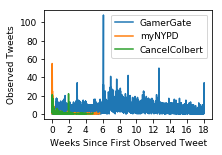

In [31]:
fig, ax = plt.subplots(figsize=(3,2))
df = hashtag_df(gg_df, 'gamergate').groupby(pd.TimeGrouper(freq='15min'))['id'].count()
plt.plot(np.arange(len(df)), df.values, label='GamerGate')
xticks_raw = np.arange(len(df))
df = hashtag_df(storm_dfs[3], 'mynypd').groupby(pd.TimeGrouper(freq='15min'))['id'].count()
plt.plot(np.arange(len(df)), df.values, label='myNYPD')
df = hashtag_df(storm_dfs[2], 'cancelcolbert').groupby(pd.TimeGrouper(freq='15min'))['id'].count()
plt.plot(np.arange(len(df)), df.values, label='CancelColbert')
plt.legend()
plt.ylabel('Observed Tweets')
plt.xlabel('Weeks Since First Observed Tweet')
ax.set_xticks(xticks_raw[::2*672])
ax.set_xticklabels([val // 672 for val in xticks_raw[::2*672]])
plt.savefig('figs/tempest/hashtag_activity_15min_combined.pdf', bbox_inches='tight')
plt.show()

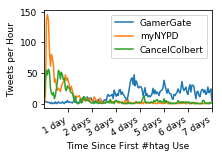

In [41]:
fig, ax = plt.subplots(figsize=(3,2))
df = hashtag_df(gg_df, 'gamergate').first('7d').groupby(pd.TimeGrouper('1h'))['id'].count()
df.index -= df.index[0]
df.plot(ax=ax, label='GamerGate')
df = hashtag_df(storm_dfs[3], 'mynypd').first('7d').groupby(pd.TimeGrouper('1h'))['id'].count()
df.index -= df.index[0]
df.plot(ax=ax, label='myNYPD')
df = hashtag_df(storm_dfs[2], 'cancelcolbert').first('7d').groupby(pd.TimeGrouper('1h'))['id'].count()
df.index -= df.index[0]
df.plot(ax=ax, label='CancelColbert')
fig.autofmt_xdate()
plt.legend()
day = lambda d: 60 * 60 * 24 * d * 1e9
plt.xticks([day(1), day(2), day(3), day(4), day(5), day(6), day(7)], ['1 day', '2 days', '3 days', '4 days', '5 days', '6 days', '7 days'])
plt.xlabel('Time Since First #htag Use')
plt.ylabel('Tweets per Hour')
plt.savefig('figs/day-zero/tweets-per-hour.pdf', bbox_inches='tight')
plt.show()

**Tweets per User**

This plot is mostly useful simply to compare shapes, but it is still interesting to note how divergent GG is from myNYPD and CancelColbert.

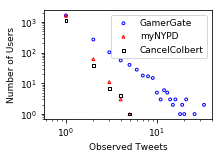

In [38]:
gg_vc = hashtag_df(gg_df, 'gamergate').first('2W').groupby(['user.id'])['id'].count().value_counts()
ny_vc = hashtag_df(storm_dfs[3], 'mynypd').first('2W').groupby(['user.id'])['id'].count().value_counts()
cc_vc = hashtag_df(storm_dfs[2], 'cancelcolbert').first('2W').groupby(['user.id'])['id'].count().value_counts()
fig, ax = plt.subplots(figsize=(3,2))
plt.scatter(gg_vc.index, gg_vc.values, s=8, facecolors='none', edgecolors='b', label='GamerGate')
plt.scatter(ny_vc.index, ny_vc.values, s=8, facecolors='none', edgecolors='r', marker='^', label='myNYPD')
plt.scatter(cc_vc.index, cc_vc.values, s=8, facecolors='none', edgecolors='k', marker='s', label='CancelColbert')
plt.ylabel('Number of Users')
plt.xscale('log')
plt.xlabel('Observed Tweets')
plt.yscale('log')
plt.legend()
plt.savefig('figs/tempest/hashtag_tweets-per-user_2weeks.pdf', bbox_inches='tight')
plt.show()

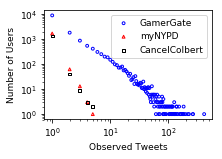

In [39]:
gg_vc = hashtag_df(gg_df, 'gamergate').groupby(['user.id'])['id'].count().value_counts()
ny_vc = hashtag_df(storm_dfs[3], 'mynypd').groupby(['user.id'])['id'].count().value_counts()
cc_vc = hashtag_df(storm_dfs[2], 'cancelcolbert').groupby(['user.id'])['id'].count().value_counts()
fig, ax = plt.subplots(figsize=(3,2))
plt.scatter(gg_vc.index, gg_vc.values, s=8, facecolors='none', edgecolors='b', label='GamerGate')
plt.scatter(ny_vc.index, ny_vc.values, s=8, facecolors='none', edgecolors='r', marker='^', label='myNYPD')
plt.scatter(cc_vc.index, cc_vc.values, s=8, facecolors='none', edgecolors='k', marker='s', label='CancelColbert')
plt.ylabel('Number of Users')
plt.xscale('log')
plt.xlabel('Observed Tweets')
plt.yscale('log')
plt.legend()
plt.savefig('figs/tempest/hashtag_tweets-per-user_2weeks.pdf', bbox_inches='tight')
plt.show()

**Unique Users**

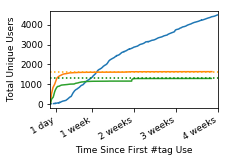

In [42]:
fig, ax = plt.subplots(figsize=(3,2))
df = (hashtag_df(gg_df, 'gamergate').first('28d').reset_index().groupby('user.id').first().set_index('created_at').sort_values('id')['id'] > 0).cumsum().groupby(pd.TimeGrouper('1h')).last()
df.index -= df.index[0]
df.plot(ax=ax, label='GamerGate')
df = (hashtag_df(storm_dfs[3], 'mynypd').first('28d').reset_index().groupby('user.id').first().set_index('created_at').sort_values('id')['id'] > 0).cumsum().groupby(pd.TimeGrouper('1h')).last().diff().fillna(0).cumsum()
df.index -= df.index[0]
df.plot(ax=ax, label='myNYPD')
plt.axhline(df.iloc[-1], c='orange', ls='dotted')
df = (hashtag_df(storm_dfs[2], 'cancelcolbert').first('28d').reset_index().groupby('user.id').first().set_index('created_at').sort_values('id')['id'] > 0).cumsum().groupby(pd.TimeGrouper('1h')).last().diff().fillna(0).cumsum()
df.index -= df.index[0]
df.plot(ax=ax, label='CancelColbert')
plt.axhline(df.iloc[-1], c='green', ls='dotted')
plt.xticks([day(1), day(7), day(14), day(21), day(28)], ['1 day', '1 week', '2 weeks', '3 weeks', '4 weeks'])
plt.ylabel('Total Unique Users')
plt.xlabel('Time Since First #tag Use')
fig.autofmt_xdate()
plt.savefig('figs/day-zero/unique-users.pdf', bbox_inches='tight')
plt.show()

### Tempest Hypotheses

In [53]:
gg_ref_pt = pd.to_datetime('28 August 2014')
gg_8wk_df = gg_df[(gg_df.index >= gg_ref_pt - pd.to_timedelta('14d')) & (gg_df.index <= gg_ref_pt + pd.to_timedelta('42d'))]

**(TH1) Tempest Hypothesis 1:** GG users tweeted on `#GamerGate` more per-user than other storms.

In [149]:
def tempest_hyp1(gg_df, ref_df, alt='greater'):
    assert(len(ref_df) > 0)
    gg_counts = gg_df.first('8W').groupby(['user.id'])['id'].count()
    ref_counts = ref_df.first('8W').groupby(['user.id'])['id'].count()
    mwu = stats.mannwhitneyu(gg_counts, ref_counts, alternative=alt)
    es = effect_size(gg_counts, ref_counts, alt)
    return {
        'kind': 'mwu',
        'stat': {'pvalue': mwu.pvalue, 'statistic': mwu.statistic},
        'effect_size': {'r': es.rbc, 'c': es.cles},
    }

In [228]:
storm_tempest_hyp1 = pd.io.json.json_normalize([tempest_hyp1(hashtag_df(gg_8wk_df, 'gamergate'), relevant_df(df, key)) for key, df in storm_dfs.items()]).join(storms)
storm_tempest_hyp1

effect_size.c  effect_size.r kind    stat.pvalue  stat.statistic  \
0        0.387429       0.370191  mwu   0.000000e+00      15970238.0   
1        0.385223       0.358363  mwu  5.765164e-145       5629715.0   
2        0.385379       0.359878  mwu  1.581342e-138       5301295.5   
3        0.384678       0.355716  mwu  4.983991e-167       6707976.5   
4        0.388424       0.374751  mwu  8.571126e-130       4538661.0   
5        0.388115       0.373856  mwu   0.000000e+00      13397242.0   
6        0.389510       0.380857  mwu  3.730170e-162       5601840.5   
7        0.385633       0.360995  mwu  5.780841e-250      10284027.5   
8        0.389871       0.382605  mwu   3.395672e-81       2620631.0   
9        0.390276       0.384837  mwu  6.816108e-120       3945128.5   
10       0.383800       0.352173  mwu   1.744657e-48       1755811.5   
11       0.389863       0.382561  mwu   1.786513e-32        977816.0   
12       0.388316       0.374031  mwu   7.230989e-27        827959.5   
13       0.386618       0.365169  mwu   4.633688e-34       1119998.5   
14       0.386439       0.364259  mwu   6.556901e-30        976451.0   
15       0.390353       0.385755  mwu   2.478952e-38       1152568.5   

           type             name        date  
0       hashtag  whyimvotingukip  2014-05-20  
1       hashtag       muslimrage  2012-09-17  
2       hashtag    CancelColbert  2014-03-27  
3       hashtag           myNYPD  2014-04-22  
4       hashtag        AskThicke  2014-06-30  
5          user         14075928  2013-02-24  
6          user         56377143  2014-06-29  
7          user        103065157  2014-03-05  
8   screen_name    celebboutique  2012-07-20  
9          user        109387470  2014-06-29  
10      hashtag           AskJPM  2013-11-06  
11      hashtag       McDStories  2012-01-18  
12      hashtag            AskBG  2013-10-17  
13      hashtag    VogueArticles  2014-09-10  
14         user        188001904  2014-06-25  
15         user       1226598505  2013-12-06

**(TH2) Tempest Hypothesis 2:** GG had more unique daily active users than other storms.

In [165]:
def tempest_hyp2(gg_df, ref_df, alt='greater'):
    assert(len(ref_df) > 0)
    gg_counts = gg_df.first('8W').groupby(pd.TimeGrouper(freq='1D'))['user.id'].nunique()
    ref_counts = ref_df.first('8W').groupby(pd.TimeGrouper(freq='1D'))['user.id'].nunique()
    mwu = stats.mannwhitneyu(gg_counts, ref_counts, alternative=alt)
    es = effect_size(gg_counts, ref_counts, alt)
    return {
        'kind': 'mwu',
        'stat': {'pvalue': mwu.pvalue, 'statistic': mwu.statistic},
        'effect_size': {'r': es.rbc, 'c': es.cles},
    }

In [229]:
storm_tempest_hyp2 = pd.io.json.json_normalize([tempest_hyp2(hashtag_df(gg_8wk_df, 'gamergate'), relevant_df(df, key)) for key, df in storm_dfs.items()]).join(storms)
storm_tempest_hyp2

effect_size.c  effect_size.r kind   stat.pvalue  stat.statistic  \
0        0.947279       0.894558  mwu  8.122952e-13          1671.0   
1        0.963719       0.927438  mwu  1.091333e-13          1700.0   
2        0.964986       0.929972  mwu  2.001680e-12          1378.0   
3        0.948897       0.897793  mwu  9.425278e-13          1634.0   
4        0.973356       0.946712  mwu  2.232352e-14          1717.0   
5        0.964286       0.928997  mwu  2.251929e-15          2268.5   
6        0.979167       0.958333  mwu  2.962862e-16          2303.0   
7        0.969577       0.939594  mwu  1.827811e-15          2199.5   
8        0.979592       0.959184  mwu  1.504687e-15          2016.0   
9        0.979592       0.959184  mwu  2.268822e-16          2304.0   
10       0.995370       0.990741  mwu  2.556895e-14          1505.0   
11       0.997732       0.995465  mwu  1.125236e-15          1760.0   
12       0.993506       0.987013  mwu  2.992800e-07           459.0   
13       0.996599       0.993197  mwu  3.040361e-14          1465.0   
14       0.998652       0.997305  mwu  3.118439e-17          2223.0   
15       0.994048       0.988946  mwu  1.261731e-12          1169.5   

           type             name        date  
0       hashtag  whyimvotingukip  2014-05-20  
1       hashtag       muslimrage  2012-09-17  
2       hashtag    CancelColbert  2014-03-27  
3       hashtag           myNYPD  2014-04-22  
4       hashtag        AskThicke  2014-06-30  
5          user         14075928  2013-02-24  
6          user         56377143  2014-06-29  
7          user        103065157  2014-03-05  
8   screen_name    celebboutique  2012-07-20  
9          user        109387470  2014-06-29  
10      hashtag           AskJPM  2013-11-06  
11      hashtag       McDStories  2012-01-18  
12      hashtag            AskBG  2013-10-17  
13      hashtag    VogueArticles  2014-09-10  
14         user        188001904  2014-06-25  
15         user       1226598505  2013-12-06

**(TH3) Tempest Hypothesis 3:** GG was tweeted about more per-day than other storms.

In [163]:
def tempest_hyp3(gg_df, ref_df, alt='greater'):
    assert(len(ref_df) > 0)
    gg_counts = gg_df.first('8W').groupby(pd.TimeGrouper(freq='1D'))['id'].count()
    ref_counts = ref_df.first('8W').groupby(pd.TimeGrouper(freq='1D'))['id'].count()
    mwu = stats.mannwhitneyu(gg_counts, ref_counts, alternative=alt)
    es = effect_size(gg_counts, ref_counts, alt)
    return {
        'kind': 'mwu',
        'stat': {'pvalue': mwu.pvalue, 'statistic': mwu.statistic},
        'effect_size': {'r': es.rbc, 'c': es.cles},
    }

In [230]:
storm_tempest_hyp3 = pd.io.json.json_normalize([tempest_hyp3(hashtag_df(gg_8wk_df, 'gamergate'), relevant_df(df, key)) for key, df in storm_dfs.items()]).join(storms)
storm_tempest_hyp3

effect_size.c  effect_size.r kind   stat.pvalue  stat.statistic  \
0        0.948413       0.896825  mwu  7.138792e-13          1673.0   
1        0.970522       0.941610  mwu  4.692152e-14          1712.5   
2        0.964986       0.929972  mwu  1.999663e-12          1378.0   
3        0.954704       0.909408  mwu  4.912873e-13          1644.0   
4        0.973356       0.946712  mwu  2.232352e-14          1717.0   
5        0.965986       0.931973  mwu  1.844045e-15          2272.0   
6        0.981293       0.962585  mwu  2.208142e-16          2308.0   
7        0.981041       0.962522  mwu  3.874255e-16          2225.5   
8        0.982021       0.964043  mwu  1.115011e-15          2021.0   
9        0.985544       0.971514  mwu  9.547008e-17          2318.5   
10       0.996032       0.992063  mwu  2.372460e-14          1506.0   
11       0.997732       0.995465  mwu  1.125236e-15          1760.0   
12       0.993506       0.987013  mwu  2.992800e-07           459.0   
13       0.996599       0.993878  mwu  2.922092e-14          1465.5   
14       0.999102       0.998203  mwu  2.932005e-17          2224.0   
15       0.997449       0.994898  mwu  9.332417e-13          1173.0   

           type             name        date  
0       hashtag  whyimvotingukip  2014-05-20  
1       hashtag       muslimrage  2012-09-17  
2       hashtag    CancelColbert  2014-03-27  
3       hashtag           myNYPD  2014-04-22  
4       hashtag        AskThicke  2014-06-30  
5          user         14075928  2013-02-24  
6          user         56377143  2014-06-29  
7          user        103065157  2014-03-05  
8   screen_name    celebboutique  2012-07-20  
9          user        109387470  2014-06-29  
10      hashtag           AskJPM  2013-11-06  
11      hashtag       McDStories  2012-01-18  
12      hashtag            AskBG  2013-10-17  
13      hashtag    VogueArticles  2014-09-10  
14         user        188001904  2014-06-25  
15         user       1226598505  2013-12-06

**(TH4) Tempest Hypothesis 4:** GG gained more DAU per-day than other storms

In [236]:
def tempest_hyp4(gg_df, ref_df, alt='greater'):
    assert(len(ref_df) > 0)
    gg_counts = gg_df.first('8W').groupby(pd.TimeGrouper(freq='1D'))['user.id'].nunique().diff()[1:]
    ref_counts = ref_df.first('8W').groupby(pd.TimeGrouper(freq='1D'))['user.id'].nunique().diff()[1:]
    mwu = stats.mannwhitneyu(gg_counts, ref_counts, alternative=alt)
    es = effect_size(gg_counts, ref_counts, alt)
    return {
        'kind': 'mwu',
        'stat': {'pvalue': mwu.pvalue, 'statistic': mwu.statistic},
        'effect_size': {'r': es.rbc, 'c': es.cles},
    }

In [237]:
storm_tempest_hyp4 = pd.io.json.json_normalize([tempest_hyp4(hashtag_df(gg_8wk_df, 'gamergate'), relevant_df(df, key)) for key, df in storm_dfs.items()]).join(storms)
storm_tempest_hyp4

effect_size.c  effect_size.r kind  stat.pvalue  stat.statistic  \
0        0.497918       0.001785  mwu     0.496297           842.0   
1        0.499703       0.001785  mwu     0.496287           842.0   
2        0.509239       0.023651  mwu     0.433019           692.5   
3        0.484146      -0.028049  mwu     0.587978           797.0   
4        0.485425      -0.026770  mwu     0.585173           818.0   
5        0.482040      -0.032373  mwu     0.607987          1091.0   
6        0.479823      -0.034590  mwu     0.615109          1088.5   
7        0.485044      -0.024390  mwu     0.581558          1060.0   
8        0.466463      -0.064533  mwu     0.701279           920.5   
9        0.473171      -0.050554  mwu     0.665223          1070.5   
10       0.467596      -0.062021  mwu     0.680950           673.0   
11       0.473528      -0.050565  mwu     0.655819           798.0   
12       0.521951       0.051220  mwu     0.406194           215.5   
13       0.477044      -0.041607  mwu     0.623660           668.0   
14       0.462946      -0.070826  mwu     0.722166           990.5   
15       0.467028      -0.062331  mwu     0.670045           519.0   

           type             name        date  
0       hashtag  whyimvotingukip  2014-05-20  
1       hashtag       muslimrage  2012-09-17  
2       hashtag    CancelColbert  2014-03-27  
3       hashtag           myNYPD  2014-04-22  
4       hashtag        AskThicke  2014-06-30  
5          user         14075928  2013-02-24  
6          user         56377143  2014-06-29  
7          user        103065157  2014-03-05  
8   screen_name    celebboutique  2012-07-20  
9          user        109387470  2014-06-29  
10      hashtag           AskJPM  2013-11-06  
11      hashtag       McDStories  2012-01-18  
12      hashtag            AskBG  2013-10-17  
13      hashtag    VogueArticles  2014-09-10  
14         user        188001904  2014-06-25  
15         user       1226598505  2013-12-06

**(TH5) Tempest Hypothesis 5:** GG users with at least two tweets gained fewer followers (as measured by final followers - initial followers)

In [20]:
def tempest_hyp5(gg_df, ref_df, alt='greater'):
    def delta_counts(df):
        initial_counts = df.groupby('user.id')['user.followers_count'].apply(lambda ser: ser.iloc[0])
        offset_counts = df.groupby('user.id')['user.followers_count'].apply(lambda ser: ser.iloc[-1] if len(ser) > 1 else np.nan)
        result = offset_counts - initial_counts
        return result
    gg_counts = delta_counts(gg_df.first('8W')).dropna()
    ref_counts = delta_counts(ref_df.first('8W')).dropna()
    mwu = stats.mannwhitneyu(gg_counts, ref_counts, alternative=alt)
    es = effect_size(gg_counts, ref_counts, alt)
    return {
        'kind': 'mwu',
        'stat': {'pvalue': mwu.pvalue, 'statistic': mwu.statistic},
        'effect_size': {'r': es.rbc, 'c': es.cles},
    }

In [21]:
storm_tempest_hyp5 = pd.io.json.json_normalize([tempest_hyp5(gg_8wk_df, df) for key, df in storm_dfs.items()]).join(storms)
storm_tempest_hyp5

effect_size.c  effect_size.r kind   stat.pvalue  stat.statistic  \
0        0.556288       0.132028  mwu  1.216694e-28      15424876.0   
1        0.454559      -0.076192  mwu  9.999938e-01       4939423.5   
2        0.475886      -0.031636  mwu  9.592671e-01       4713311.5   
3        0.442114      -0.101748  mwu  1.000000e+00       5668043.0   
4        0.495072       0.007368  mwu  3.555233e-01       3996907.0   
5        0.567368       0.155709  mwu  1.333775e-40      16664646.0   
6        0.516703       0.052545  mwu  1.499456e-03       5426766.5   
7        0.454798      -0.074977  mwu  1.000000e+00      11214677.0   
8        0.493847       0.004881  mwu  4.178170e-01       2763210.0   
9        0.563452       0.148095  mwu  3.270068e-13       4214228.5   
10       0.454970      -0.073558  mwu  9.853615e-01       1191201.0   
11       0.450741      -0.084121  mwu  9.731722e-01        695689.0   
12       0.440592      -0.103707  mwu  9.896330e-01        642778.0   
13       0.511755       0.039739  mwu  1.402762e-01       1116269.0   
14       0.485506      -0.012626  mwu  6.277676e-01        955302.5   
15       0.558056       0.136993  mwu  1.524037e-04       1148309.5   

           type             name        date  
0       hashtag  whyimvotingukip  2014-05-20  
1       hashtag       muslimrage  2012-09-17  
2       hashtag    CancelColbert  2014-03-27  
3       hashtag           myNYPD  2014-04-22  
4       hashtag        AskThicke  2014-06-30  
5          user         14075928  2013-02-24  
6          user         56377143  2014-06-29  
7          user        103065157  2014-03-05  
8   screen_name    celebboutique  2012-07-20  
9          user        109387470  2014-06-29  
10      hashtag           AskJPM  2013-11-06  
11      hashtag       McDStories  2012-01-18  
12      hashtag            AskBG  2013-10-17  
13      hashtag    VogueArticles  2014-09-10  
14         user        188001904  2014-06-25  
15         user       1226598505  2013-12-06

In [23]:
def tempest_hyp6(gg_df, ref_df, alt='greater'):
    def delta_counts(df):
        initial_counts = df.groupby('user.id')['user.friends_count'].apply(lambda ser: ser.iloc[0])
        offset_counts = df.groupby('user.id')['user.friends_count'].apply(lambda ser: ser.iloc[-1] if len(ser) > 1 else np.nan)
        result = offset_counts - initial_counts
        return result
    gg_counts = delta_counts(gg_df.first('8W')).dropna()
    ref_counts = delta_counts(ref_df.first('8W')).dropna()
    mwu = stats.mannwhitneyu(gg_counts, ref_counts, alternative=alt)
    es = effect_size(gg_counts, ref_counts, alt)
    return {
        'kind': 'mwu',
        'stat': {'pvalue': mwu.pvalue, 'statistic': mwu.statistic},
        'effect_size': {'r': es.rbc, 'c': es.cles},
    }

In [24]:
storm_tempest_hyp6 = pd.io.json.json_normalize([tempest_hyp6(gg_8wk_df, df) for key, df in storm_dfs.items()]).join(storms)
storm_tempest_hyp6

effect_size.c  effect_size.r kind   stat.pvalue  stat.statistic  \
0        0.565716       0.149527  mwu  3.550954e-36      15663313.5   
1        0.529940       0.075611  mwu  7.158721e-06       5751086.0   
2        0.503018       0.022792  mwu  1.047023e-01       4978229.0   
3        0.507280       0.029879  mwu  3.278514e-02       6498623.5   
4        0.553602       0.124609  mwu  1.861091e-10       4462078.5   
5        0.530931       0.080078  mwu  4.123102e-12      15574085.5   
6        0.555074       0.129363  mwu  1.366541e-13       5822831.5   
7        0.478989      -0.027096  mwu  9.850084e-01      11795174.0   
8        0.504326       0.023882  mwu  1.550068e-01       2815458.0   
9        0.558675       0.137699  mwu  1.160582e-11       4176070.5   
10       0.516269       0.050846  mwu  6.593770e-02       1351157.5   
11       0.502933       0.021993  mwu  3.069633e-01        776292.0   
12       0.484715      -0.015475  mwu  6.350044e-01        706053.5   
13       0.572894       0.162652  mwu  5.006234e-06       1248230.0   
14       0.554642       0.126161  mwu  5.630428e-04       1089581.5   
15       0.577850       0.173469  mwu  2.406329e-06       1185148.5   

           type             name        date  
0       hashtag  whyimvotingukip  2014-05-20  
1       hashtag       muslimrage  2012-09-17  
2       hashtag    CancelColbert  2014-03-27  
3       hashtag           myNYPD  2014-04-22  
4       hashtag        AskThicke  2014-06-30  
5          user         14075928  2013-02-24  
6          user         56377143  2014-06-29  
7          user        103065157  2014-03-05  
8   screen_name    celebboutique  2012-07-20  
9          user        109387470  2014-06-29  
10      hashtag           AskJPM  2013-11-06  
11      hashtag       McDStories  2012-01-18  
12      hashtag            AskBG  2013-10-17  
13      hashtag    VogueArticles  2014-09-10  
14         user        188001904  2014-06-25  
15         user       1226598505  2013-12-06

### Chatzakou Hypotheses

Quick comparisons to a random sample of users as a point of comparison to Chatzakou et al, 2017. We measure each property (number of friends, followers, and tweets) by their associated properties on the user object. When more than one tweet for a user is observed, we use the *first* such tweet. Thus, these are the *initial* friend/follower/tweet count in the observed data.

**(CZ1) Chatzakou Hypothesis 1:** GG users had fewer friends than a random sample of users.

In [210]:
def chatzakou_hyp(gg_df, rand_df, field, alt='less'):
    gg_counts = gg_df.groupby('user.id')[field].agg(lambda ser: ser.iloc[0]).dropna()
    rand_counts = rand_df.groupby('user.id')[field].agg(lambda ser: ser.iloc[0]).dropna()
    mwu = stats.mannwhitneyu(gg_counts, rand_counts, alternative=alt)
    es = effect_size(gg_counts, rand_counts, alt)
    return {
        'kind': 'mwu',
        'stat': {'pvalue': mwu.pvalue, 'statistic': mwu.statistic},
        'effect_size': {'r': es.rbc, 'c': es.cles},
    }

In [211]:
def chatzakou_hyp1(gg_df, rand_df, alt='less'):
    return chatzakou_hyp(gg_df, rand_df, 'user.friends_count', alt)

In [233]:
chatzakou_hyp1(gg_df.first('4W'), rand_df.first('4W'))

{'effect_size': {'c': 0.5187940167691323, 'r': 0.03866573195595113},
 'kind': 'mwu',
 'stat': {'pvalue': 0.00014330786165912585, 'statistic': 16580520.5}}

**(CZ2) Chatzakou Hypothesis 2:** GG users had fewer followers than a random sample of users.

In [219]:
def chatzakou_hyp2(gg_df, rand_df, alt='less'):
    return chatzakou_hyp(gg_df, rand_df, 'user.followers_count', alt)

In [234]:
chatzakou_hyp2(gg_df.first('4W'), rand_df.first('4W'))

{'effect_size': {'c': 0.5778298867470142, 'r': 0.15676521521731618},
 'kind': 'mwu',
 'stat': {'pvalue': 2.965178384184979e-49, 'statistic': 14543611.0}}

**(CZ3) Chatzakou Hypothesis 3:** GG users had fewer tweets than a random sample of users.

In [217]:
def chatzakou_hyp3(gg_df, rand_df, alt='less'):
    return chatzakou_hyp(gg_df, rand_df, 'user.statuses_count', alt)

In [235]:
chatzakou_hyp3(gg_df.first('4W'), rand_df.first('4W'))

{'effect_size': {'c': 0.5219394756451463, 'r': 0.04393168386384405},
 'kind': 'mwu',
 'stat': {'pvalue': 1.8854746170940502e-05, 'statistic': 16489696.5}}

### Community Hypotheses

**RQ:** Was a community present amoungst GG users? If so, does this distinguish it from other events? 

**(CH1) Community Hypothesis 1:** Users that participated in a storm had significantly different mention behavior.

*Note:* we use the $\chi^2$ test here, which is *two-sided*. The correlation coefficient $\phi$ tells us the direction of the correlation. The way the contingency tables are constructed, a positive $\phi$ indicates that the storm users had a higher in-mention rate and a negative $\phi$ the opposite.

In [34]:
def compare_to_random(df):
    combined = pd.concat([df, rand_df])
    return c.test_vs_random(combined, c.mdf(combined), df['user.id'].unique(), rand_df['user.id'].unique())

In [40]:
storm_comm_tests = pd.io.json.json_normalize([compare_to_random(df) for df in storm_dfs.values()]).join(storms)
storm_comm_tests

effect_size.phi  kind  stat.dof    stat.pvalue  stat.statistic  \
0          0.041513  chi2         1   3.052990e-29      126.014147   
1          0.055471  chi2         1   1.147885e-48      214.941181   
2          0.133591  chi2         1  1.419393e-275     1258.130790   
3          0.081702  chi2         1  2.105247e-107      484.625280   
4          0.028533  chi2         1   1.604100e-13       54.438250   
5          0.018650  chi2         1   2.446325e-07       26.643816   
6          0.189536  chi2         1   0.000000e+00     2450.464693   
7          0.118541  chi2         1  3.603178e-249     1136.634579   
8          0.124795  chi2         1  3.396397e-230     1049.334317   
9         -0.014667  chi2         1   2.590000e-04       13.345815   
10         0.013214  chi2         1   1.132595e-03       10.597192   
11         0.000815  chi2         1   9.184286e-01        0.010488   
12         0.005292  chi2         1   2.194506e-01        1.507961   
13         0.010271  chi2         1   1.268173e-02        6.212976   
14         0.020904  chi2         1   2.430986e-07       26.655969   
15        -0.004851  chi2         1   2.608910e-01        1.264023   

                                     table         type             name  \
0    [[464.0, 11342.0], [1345.0, 60393.0]]      hashtag  whyimvotingukip   
1     [[410.0, 8077.0], [1343.0, 60378.0]]      hashtag       muslimrage   
2     [[810.0, 8097.0], [1343.0, 60378.0]]      hashtag    CancelColbert   
3    [[653.0, 10430.0], [1344.0, 60383.0]]      hashtag           myNYPD   
4     [[220.0, 5746.0], [1343.0, 60378.0]]      hashtag        AskThicke   
5    [[452.0, 15284.0], [1343.0, 60404.0]]         user         14075928   
6     [[897.0, 5695.0], [1343.0, 60378.0]]         user         56377143   
7   [[1388.0, 17889.0], [1343.0, 60378.0]]         user        103065157   
8     [[555.0, 5275.0], [1343.0, 60378.0]]  screen_name    celebboutique   
9      [[28.0, 2542.0], [1343.0, 60515.0]]         user        109387470   
10     [[64.0, 1871.0], [1343.0, 60378.0]]      hashtag           AskJPM   
11     [[26.0, 1122.0], [1343.0, 60378.0]]      hashtag       McDStories   
12     [[33.0, 1171.0], [1343.0, 60378.0]]      hashtag            AskBG   
13     [[47.0, 1435.0], [1343.0, 60378.0]]      hashtag    VogueArticles   
14     [[61.0, 1377.0], [1343.0, 60378.0]]         user        188001904   
15     [[23.0, 1338.0], [1343.0, 60378.0]]         user       1226598505   

          date  
0   2014-05-20  
1   2012-09-17  
2   2014-03-27  
3   2014-04-22  
4   2014-06-30  
5   2013-02-24  
6   2014-06-29  
7   2014-03-05  
8   2012-07-20  
9   2014-06-29  
10  2013-11-06  
11  2012-01-18  
12  2013-10-17  
13  2014-09-10  
14  2014-06-25  
15  2013-12-06

In [51]:
storm_comm_tests['fmt_name'] = storm_comm_tests[['type','name']].apply(lambda row: format_storm_name(*row.values),axis=1)
storm_comm_tests['imr'] = storm_comm_tests['table'].apply(lambda table: table[0,0] / table[0,:].sum())

fmt_exp = lambda v: r'\num{{{:e}}}'.format(v)
fmt_float = lambda v: r'\num{{{}}}'.format(v)
print(storm_comm_tests[['fmt_name', 'stat.pvalue', 'stat.statistic', 'effect_size.phi', 'imr']].sort_values('effect_size.phi', ascending=False).set_index('fmt_name').to_latex(formatters=[fmt_exp, fmt_float, fmt_float, fmt_float], escape=False))

#print(pro_v_anti_results[['name']].sort_values('effect_size.r', ascending=False).set_index('screen_name').to_latex(formatters=[lambda v: r'\num{{{:e}}}'.format(v) if type(v) == float else r'\num{{{}}}'.format(v)] * 5, escape=False))

\begin{tabular}{lrrrr}
\toprule
{} &         stat.pvalue &             stat.statistic &             effect_size.phi &                        imr \\
fmt_name         &                     &                            &                             &                            \\
\midrule
@KLM             &  \num{0.000000e+00} &    \num{2450.464692741731} &   \num{0.18953595153738387} &  \num{0.13607402912621358} \\
#CancelColbert   & \num{1.419393e-275} &   \num{1258.1307903791394} &   \num{0.13359121101210722} &  \num{0.09093971034018188} \\
@celebboutique   & \num{3.396397e-230} &   \num{1049.3343169953791} &   \num{0.12479480072454209} &  \num{0.09519725557461406} \\
@David_Cameron   & \num{3.603178e-249} &    \num{1136.634578513807} &   \num{0.11854073224238944} &  \num{0.07200290501634071} \\
#myNYPD          & \num{2.105247e-107} &   \num{484.62527950179316} &   \num{0.08170151781401333} & \num{0.058919065235044664} \\
#muslimrage      &  \num{1.147885e-48} &   \num{214.94118069393

In [54]:
gg_result = compare_to_random(gg_8wk_df)
gg_result

{'effect_size': {'phi': 0.3984771821933461},
 'kind': 'chi2',
 'stat': {'dof': 1, 'pvalue': 0.0, 'statistic': 20934.741873922096},
 'table': array([[23284., 46654.],
        [ 1346., 60573.]])}

In [19]:
gg_result_post_storm = compare_to_random(gg_df.last('2W'))
gg_result_post_storm

{'effect_size': {'phi': 0.4919963067516596},
 'kind': 'chi2',
 'stat': {'dof': 1, 'pvalue': 0.0, 'statistic': 18615.15634384479},
 'table': array([[ 6035.,  9848.],
        [ 1344., 59693.]])}

**(CH2) Community Hypothesis 2:** Users involved in non-GG storms had significantly lower per-day IMR than GG users.

**TODO:** wording

In [15]:
def compare_to_gg(df):
    combined = pd.concat([df, gg_8wk_df])
    return c.test_vs_random(combined, c.mdf(combined), df['user.id'].unique(), gg_8wk_df['user.id'].unique())

In [16]:
storm_comm_tests_gg = pd.io.json.json_normalize([compare_to_gg(df) for df in storm_dfs.values()]).join(storms)
storm_comm_tests_gg

effect_size.phi  kind  stat.dof    stat.pvalue  stat.statistic  \
0         -0.228663  chi2         1   0.000000e+00     4275.487127   
1         -0.193020  chi2         1   0.000000e+00     2915.102007   
2         -0.168929  chi2         1   0.000000e+00     2275.704374   
3         -0.207479  chi2         1   0.000000e+00     3500.411985   
4         -0.174246  chi2         1   0.000000e+00     2302.703415   
5         -0.264342  chi2         1   0.000000e+00     6025.088563   
6         -0.118906  chi2         1  2.141349e-236     1077.861124   
7         -0.241109  chi2         1   0.000000e+00     5215.902558   
8         -0.136551  chi2         1  5.916676e-308     1407.134555   
9         -0.123912  chi2         1  1.804627e-242     1105.808757   
10        -0.105705  chi2         1  4.461734e-176      800.379718   
11        -0.083389  chi2         1  7.890285e-109      491.179842   
12        -0.084225  chi2         1  4.214951e-111      501.623215   
13        -0.091633  chi2         1  1.105655e-131      596.230867   
14        -0.087077  chi2         1  5.130500e-119      538.001701   
15        -0.099549  chi2         1  1.541879e-155      705.921465   

                                      table         type             name  \
0    [[466.0, 11514.0], [23187.0, 46630.0]]      hashtag  whyimvotingukip   
1     [[413.0, 8128.0], [23185.0, 46554.0]]      hashtag       muslimrage   
2     [[853.0, 8590.0], [23244.0, 47099.0]]      hashtag    CancelColbert   
3    [[657.0, 10637.0], [23215.0, 46837.0]]      hashtag           myNYPD   
4     [[221.0, 5876.0], [23194.0, 46597.0]]      hashtag        AskThicke   
5    [[458.0, 15666.0], [23206.0, 46916.0]]         user         14075928   
6     [[898.0, 5704.0], [23180.0, 46518.0]]         user         56377143   
7   [[1398.0, 18243.0], [23232.0, 46872.0]]         user        103065157   
8     [[555.0, 5278.0], [23179.0, 46512.0]]  screen_name    celebboutique   
9      [[28.0, 2398.0], [23179.0, 46511.0]]         user        109387470   
10     [[64.0, 1938.0], [23182.0, 46571.0]]      hashtag           AskJPM   
11     [[26.0, 1122.0], [23179.0, 46511.0]]      hashtag       McDStories   
12     [[33.0, 1176.0], [23181.0, 46517.0]]      hashtag            AskBG   
13     [[47.0, 1435.0], [23179.0, 46511.0]]      hashtag    VogueArticles   
14     [[61.0, 1377.0], [23179.0, 46511.0]]         user        188001904   
15     [[23.0, 1550.0], [23197.0, 46609.0]]         user       1226598505   

          date  
0   2014-05-20  
1   2012-09-17  
2   2014-03-27  
3   2014-04-22  
4   2014-06-30  
5   2013-02-24  
6   2014-06-29  
7   2014-03-05  
8   2012-07-20  
9   2014-06-29  
10  2013-11-06  
11  2012-01-18  
12  2013-10-17  
13  2014-09-10  
14  2014-06-25  
15  2013-12-06

In [17]:
rand_mdf = c.mdf(rand_df)

In [332]:
def imr_plot(df, ax=None, show_rand=True):
    import matplotlib.ticker as t
    mdf = c.mdf(df)
    if ax is None:
        fig, ax = plt.subplots(figsize=(3,2))
    
    in_mentions = mdf[mdf['user.id'].isin(df['user.id']) & mdf['mention.id'].isin(df['user.id'])]
    data = df[df['id'].isin(mdf.index)].groupby(pd.TimeGrouper('1d'))['id'].agg(lambda sdf: np.count_nonzero(sdf.isin(in_mentions.index)) / max(len(sdf), 1))
    data.index -= data.index[0]
    data.index -= pd.to_timedelta('14d')
    data.plot(ax=ax)
    
    if show_rand:
        in_mentions = rand_mdf[rand_mdf['user.id'].isin(rand_df['user.id']) & rand_mdf['mention.id'].isin(rand_df['user.id'])]
        data = rand_df[rand_df['id'].isin(rand_mdf.index)].groupby(pd.TimeGrouper('1d'))['id'].agg(lambda sdf: np.count_nonzero(sdf.isin(in_mentions.index)) / len(sdf))
        data.index -= data.index[0]
        data.index -= pd.to_timedelta('14d')
        data.plot(ax=ax, label=None)
    plt.ylim([0,0.75])
    plt.xlim([-day(14),day(42)])
    ax.xaxis.set_major_locator(t.MultipleLocator(base=day(7)))
    ax.xaxis.set_major_formatter(t.FuncFormatter(lambda x, v: '{:d}'.format(int(x // (60 * 60 * 24 * 1e9 * 7)) )))
    ax.set_xlabel('Weeks From Event Date')
    ax.set_ylabel(r"$\mathcal{I}_\tau(S)$, $\tau =$ 1 day")
    if ax is None:
        plt.show()

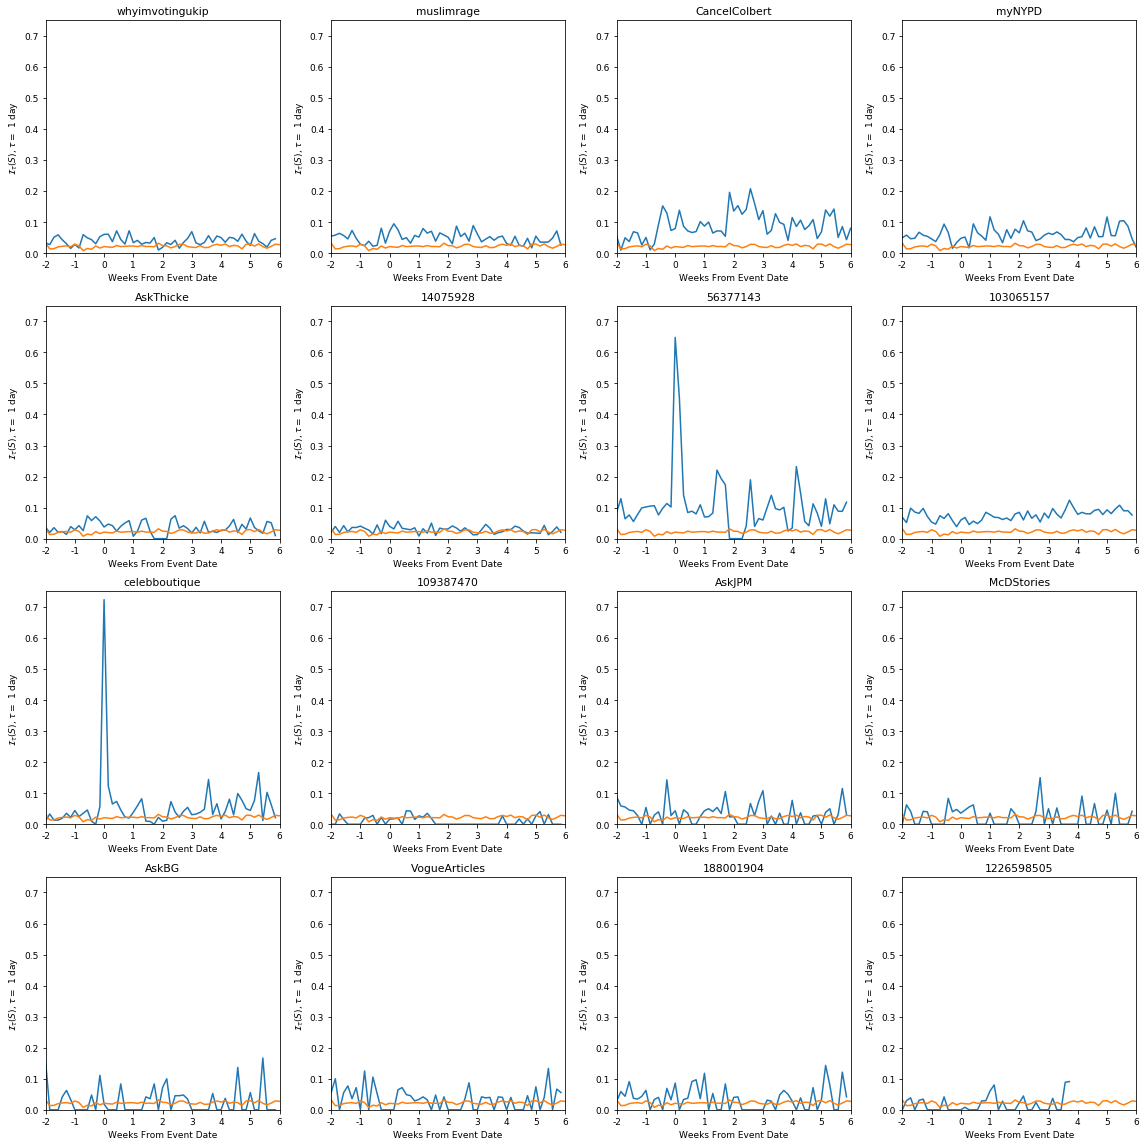

In [256]:
fig = plt.figure(figsize=(16,16))
for key, storm in storm_dfs.items():
    ax = fig.add_subplot(4,4, key+1)
    imr_plot(storm, ax=ax)
    ax.set_title(storms.loc[key]['name'])
plt.tight_layout()
plt.show()

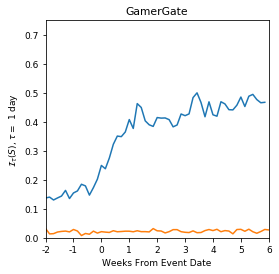

In [314]:
fig, ax = plt.subplots(figsize=(4,4))
imr_plot(gg_8wk_df, ax=ax)
ax.set_title('GamerGate')
plt.show()

Lets pick some exemplars to show off the variety of behavior in the paper.

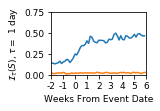

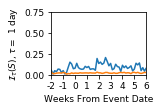

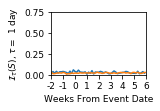

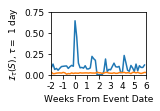

In [260]:
fig, ax = plt.subplots(figsize=(1.7,1.15))
imr_plot(gg_8wk_df, ax=ax)
plt.savefig('figs/imr/gamergate.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(1.7,1.15))
imr_plot(storm_dfs[2], ax=ax) # #CancelColbert
plt.savefig('figs/imr/cancelcolbert.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(1.7,1.15))
imr_plot(storm_dfs[5], ax=ax) # @TheOnion
plt.savefig('figs/imr/theonion.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(1.7,1.15))
imr_plot(storm_dfs[6], ax=ax) # @KLM
plt.savefig('figs/imr/klm.pdf', bbox_inches='tight')
plt.show()

**(CH3) Community Hypothesis 3:** The IMR grows over time.

In [310]:
c.test_growth(gg_8wk_df.first('14d'), gg_8wk_df.last('14d'), c.mdf(gg_8wk_df), gg_df['user.id'].unique())

{'effect_size': {'phi': 0.28584699159878213},
 'kind': 'chi2',
 'stat': {'dof': 1, 'pvalue': 0.0, 'statistic': 2683.598976422523},
 'table': array([[ 8140., 11378.],
        [ 1979., 11362.]])}

In [315]:
gg_mdf = c.mdf(gg_df)

**(CH4) Community Hypothesis 4:** This growth is reflected when comparing early August to late December 2014.

In [316]:
c.test_growth(gg_df.first('14d'), gg_df.last('14d'), gg_mdf, gg_df['user.id'].unique())

{'effect_size': {'phi': 0.28606499144734693},
 'kind': 'chi2',
 'stat': {'dof': 1, 'pvalue': 0.0, 'statistic': 2629.0659372084233},
 'table': array([[ 7856., 12138.],
        [ 1516., 10633.]])}

**(CH5) Community Hypothesis 5:** This growth peaks early and is then stabilizes.

In [319]:
c.test_growth(gg_df.first('56d').last('14d'), gg_df.last('14d'), gg_mdf, gg_df['user.id'].unique())

{'effect_size': {'phi': 0.00020978072162362415},
 'kind': 'chi2',
 'stat': {'dof': 1,
  'pvalue': 0.9756029071886951,
  'statistic': 0.0009352579697913807},
 'table': array([[ 7856., 12138.],
        [ 7189., 11117.]])}

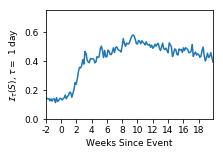

In [330]:
fig, ax = plt.subplots(figsize=(3,2))
in_mentions = gg_mdf[gg_mdf['user.id'].isin(gg_df['user.id']) & gg_mdf['mention.id'].isin(gg_df['user.id'])]
data = gg_df[gg_df['id'].isin(gg_mdf.index)].groupby(pd.TimeGrouper('1d'))['id'].agg(lambda sdf: np.count_nonzero(sdf.isin(in_mentions.index)) / max(len(sdf), 1))
data.index -= data.index[0]
data.index -= pd.to_timedelta('14d')
data.plot(ax=ax)

import matplotlib.ticker as t
ax.xaxis.set_major_locator(t.MultipleLocator(base=day(14)))
ax.xaxis.set_major_formatter(t.FuncFormatter(lambda x, v: '{:d}'.format(int(x // (60 * 60 * 24 * 1e9 * 7)) )))
plt.ylim([0,0.75])
plt.xlabel('Weeks Since Event')
plt.ylabel(r"$\mathcal{I}_\tau(S)$, $\tau=$ 1 day")
plt.savefig('figs/imr/gg_long.pdf', bbox_inches='tight')
plt.show()

### Notable Users

Next, we are interested in RQ5 (Were certain notable users central members of these communities?). To accomplish this, we need the set of notables. The list used here is pre-computed for the sake of categorization, but can be reproduced with the `c.notables(gg_df)` function.

In [4]:
anti_gg = pd.Series([226346115, 17264476, 56768257, 42067255, 13857342, 16823185, 1664892060, 177052107])
pro_gg = pd.Series([816532555, 6160792, 113137765, 2275538935, 334921581, 2472399354, 2328447870, 91279573, 2815279566, 2802424662, 530821510, 2353828890, 358545917, 2817808376])
others = pd.Series([1712939281, 41687358, 2666936809, 424806929, 147851744, 16747981, 83339474])
ids = pd.concat([anti_gg, pro_gg, others], ignore_index=True)
cats = pd.Series(pd.Categorical([*(["anti"]*len(anti_gg)), *(["pro"]*len(pro_gg)), *(["other"]*len(others))], categories=['anti', 'pro', 'other']), index=ids.index)
notables = pd.DataFrame({'user.id': ids, 'notable.category': cats}, index=ids.index)
notables

notable.category     user.id
0              anti   226346115
1              anti    17264476
2              anti    56768257
3              anti    42067255
4              anti    13857342
5              anti    16823185
6              anti  1664892060
7              anti   177052107
8               pro   816532555
9               pro     6160792
10              pro   113137765
11              pro  2275538935
12              pro   334921581
13              pro  2472399354
14              pro  2328447870
15              pro    91279573
16              pro  2815279566
17              pro  2802424662
18              pro   530821510
19              pro  2353828890
20              pro   358545917
21              pro  2817808376
22            other  1712939281
23            other    41687358
24            other  2666936809
25            other   424806929
26            other   147851744
27            other    16747981
28            other    83339474

In [9]:
pro_group = c.notable_group(gg_df, pro_gg)
anti_group = c.notable_group(gg_df, anti_gg)
non_group = gg_df[~(gg_df['user.id'].isin(pro_group) | gg_df['user.id'].isin(anti_group))]['user.id'].unique()

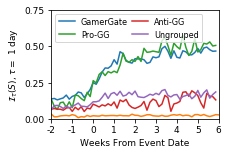

In [344]:
fig, ax = plt.subplots(figsize=(3,2))
imr_plot(gg_8wk_df, ax=ax)
imr_plot(gg_8wk_df[gg_8wk_df['user.id'].isin(pro_group)], ax=ax, show_rand=False)
imr_plot(gg_8wk_df[gg_8wk_df['user.id'].isin(anti_group)], ax=ax, show_rand=False)
imr_plot(gg_8wk_df[gg_8wk_df['user.id'].isin(non_group)], ax=ax, show_rand=False)
plt.legend([artist for i, artist in enumerate(ax.get_children()[:5]) if i != 1], 
           ['GamerGate', 'Pro-GG', 'Anti-GG', 'Ungrouped'], ncol=2, loc='upper left', fontsize=8, columnspacing=0.5)
plt.yticks([0,0.25,0.5,0.75])
plt.savefig('figs/imr/gg_groups.pdf', bbox_inches='tight')
plt.show()

In [346]:
compare_to_random(gg_8wk_df[gg_8wk_df['user.id'].isin(pro_group)])

{'effect_size': {'phi': 0.4617502366752295},
 'kind': 'chi2',
 'stat': {'dof': 1, 'pvalue': 0.0, 'statistic': 17495.42768183588},
 'table': array([[ 7399., 13926.],
        [ 1344., 59403.]])}

In [347]:
compare_to_random(gg_8wk_df[gg_8wk_df['user.id'].isin(anti_group)])

{'effect_size': {'phi': 0.15475114090093142},
 'kind': 'chi2',
 'stat': {'dof': 1, 'pvalue': 0.0, 'statistic': 1697.8735357248745},
 'table': array([[ 1049.,  9313.],
        [ 1343., 59295.]])}

In [348]:
compare_to_random(gg_8wk_df[gg_8wk_df['user.id'].isin(non_group)])

{'effect_size': {'phi': 0.2214426183828325},
 'kind': 'chi2',
 'stat': {'dof': 1, 'pvalue': 0.0, 'statistic': 4877.289623239536},
 'table': array([[ 5239., 33563.],
        [ 1345., 59352.]])}

**What is the frequency of cross-group mentions?**

Ungrouped -> Ungrouped

In [359]:
len(gg_mdf[gg_mdf['user.id'].isin(non_group) & gg_mdf['mention.id'].isin(non_group)]) / len(gg_mdf[gg_mdf['user.id'].isin(non_group)])

0.12737901271337387

Pro -> Pro

In [360]:
len(gg_mdf[gg_mdf['user.id'].isin(pro_group) & gg_mdf['mention.id'].isin(pro_group)]) / len(gg_mdf[gg_mdf['user.id'].isin(pro_group)])

0.4033062118325707

Anti -> Anti

In [361]:
len(gg_mdf[gg_mdf['user.id'].isin(anti_group) & gg_mdf['mention.id'].isin(anti_group)]) / len(gg_mdf[gg_mdf['user.id'].isin(anti_group)])

0.12272307923362441

Ungrouped -> Pro (% of all Ungrouped mentions)

In [355]:
len(gg_mdf[gg_mdf['user.id'].isin(non_group) & gg_mdf['mention.id'].isin(pro_group)]) / len(gg_mdf[gg_mdf['user.id'].isin(non_group)])

0.13880761751257029

Pro -> Ungrouped

In [356]:
len(gg_mdf[gg_mdf['user.id'].isin(pro_group) & gg_mdf['mention.id'].isin(non_group)]) / len(gg_mdf[gg_mdf['user.id'].isin(pro_group)])

0.21228657396692008

Anti -> Pro

In [357]:
len(gg_mdf[gg_mdf['user.id'].isin(anti_group) & gg_mdf['mention.id'].isin(pro_group)]) / len(gg_mdf[gg_mdf['user.id'].isin(anti_group)])

0.09910103198952992

Pro -> Anti

In [358]:
len(gg_mdf[gg_mdf['user.id'].isin(pro_group) & gg_mdf['mention.id'].isin(anti_group)]) / len(gg_mdf[gg_mdf['user.id'].isin(pro_group)])

0.062020403439742196

In [363]:
gg_notables_auto = c.notables(gg_df)

In [369]:
len(pro_group) / gg_df['user.id'].nunique()

0.21736518953550454

In [370]:
len(anti_group) / gg_df['user.id'].nunique()

0.08682594767752269

In [371]:
groups = {'Pro-GG': pro_group, 'Anti-GG': anti_group, 'Ungrouped': non_group}

items = []
for label, group in groups.items():
    for target, tgroup in groups.items():
        items.append((label, target, len(gg_mdf[gg_mdf['user.id'].isin(group) & gg_mdf['mention.id'].isin(tgroup)]) / len(gg_mdf[gg_mdf['user.id'].isin(group)])))

In [382]:
group_fracs = pd.DataFrame(items, columns=['source', 'target', 'fraction'])
print(group_fracs.groupby(['source']).apply(lambda df: df.append(pd.DataFrame([{'source': df.name, 'target': 'Other', 'fraction': 1 - df['fraction'].sum()}]))).reset_index(drop=True).pivot(index='source', columns='target').to_latex())

\begin{tabular}{lrrrr}
\toprule
{} & \multicolumn{4}{l}{fraction} \\
target &   Anti-GG &     Other &    Pro-GG & Ungrouped \\
source    &           &           &           &           \\
\midrule
Anti-GG   &  0.122723 &  0.649617 &  0.099101 &  0.128559 \\
Pro-GG    &  0.062020 &  0.322387 &  0.403306 &  0.212287 \\
Ungrouped &  0.045639 &  0.688175 &  0.138808 &  0.127379 \\
\bottomrule
\end{tabular}



In [5]:
def initial_screen_name(id):
    return gg_df[gg_df['user.id'] == id]['user.screen_name'].iloc[0]

In [6]:
gg_mdf = c.mdf(gg_df)

In [28]:
def compare_mention_rates(users, targets, alt='greater'):
    sources = c.notable_group(gg_df, users)
    nonsources = gg_df[~gg_df['user.id'].isin(sources)]['user.id'].unique()
    
    m = gg_mdf.groupby('user.id')['mention.id'].agg(lambda ser: np.count_nonzero(ser.isin(targets)))
    source_counts = m.loc[sources].fillna(0)
    nonsource_counts = m[nonsources].fillna(0)

    stat = stats.mannwhitneyu(source_counts, nonsource_counts, alternative=alt)
    es = effect_size(source_counts, nonsource_counts, alt)
    return {
        'kind': 'mwu',
        'stat': {'pvalue': stat.pvalue, 'statistic': stat.statistic},
        'effect_size': {'c': es.cles, 'r': es.rbc},
        'mean_ratio': source_counts.mean() / nonsource_counts.mean(),
        'means': { 'left': source_counts.mean(), 'right': nonsource_counts.mean() },
        'screen_name': initial_screen_name(*users) if len(users) == 1 else None,
        'counts': {'left': len(source_counts), 'right': len(nonsource_counts)}
    }

**(NT1)** Is RT'ing a Pro-GG notable correlated with mentioning Anti-GG users?

In [29]:
pro_v_anti_results = pd.io.json.json_normalize([compare_mention_rates([u], anti_group) for u in notables[notables['notable.category'] == 'pro']['user.id']])
pro_v_anti_results

counts.left  counts.right  effect_size.c  effect_size.r kind  mean_ratio  \
0          1041         13943       0.427187       0.239245  mwu    2.203465   
1           991         13993       0.430021       0.241548  mwu    2.079976   
2           600         14384       0.451261       0.263437  mwu    2.149280   
3           412         14572       0.573369       0.417854  mwu    3.300334   
4           552         14432       0.402228       0.201043  mwu    1.872154   
5           402         14582       0.472805       0.290746  mwu    2.543865   
6           546         14438       0.419032       0.221807  mwu    1.925136   
7           472         14512       0.398437       0.198249  mwu    2.051884   
8           206         14778       0.549646       0.384794  mwu    3.071992   
9           240         14744       0.627921       0.486392  mwu    3.772562   
10          116         14868       0.669660       0.540397  mwu    5.233685   
11          201         14783       0.552303       0.390206  mwu    3.443774   
12          625         14359       0.466692       0.284355  mwu    2.332916   
13          192         14792       0.471793       0.286497  mwu    2.726369   

    means.left  means.right      screen_name   stat.pvalue  stat.statistic  
0     2.739673     1.243348   FartToContinue  5.342782e-58       8993613.5  
1     2.615540     1.257486             Nero  1.542992e-56       8608313.5  
2     2.768333     1.288028   TheRalphRetort  2.155401e-42       5451981.5  
3     4.182039     1.267156   RogueStarGamez  1.279760e-72       4256158.5  
4     2.443841     1.305363        CHSommers  1.054719e-23       4784034.0  
5     3.291045     1.293718  Sargon_of_Akkad  2.009044e-35       3783154.5  
6     2.509158     1.303366   Int_Aristocrat  3.727378e-28       4815843.5  
7     2.675847     1.304093      AdamBaldwin  3.961595e-20       4103800.5  
8     4.024272     1.309988    TheIvyClover1  2.107199e-32       2107841.5  
9     4.866667     1.290016     DeadwingDuck  1.999352e-58       2629843.0  
10    6.827586     1.304547      BasedCraven  5.688008e-36       1328352.5  
11    4.492537     1.304539       CHOBITCOIN  1.625430e-32       2065416.5  
12    2.977600     1.276342  PlayDangerously  6.343233e-51       5763140.5  
13    3.593750     1.318145        Kingofpol  1.114004e-17       1826867.5

**(NT2)** Is RT'ing an Anti-GG notable correlated with mentioning Pro-GG users?

In [30]:
anti_v_pro_results = pd.io.json.json_normalize([compare_mention_rates([u], pro_group, alt='greater') for u in notables[notables['notable.category'] == 'anti']['user.id']])
anti_v_pro_results

counts.left  counts.right  effect_size.c  effect_size.r kind  mean_ratio  \
0          354         14630       0.337994       0.009996  mwu    0.867911   
1          468         14516       0.240468      -0.120038  mwu    0.511540   
2          340         14644       0.207915      -0.161806  mwu    0.449998   
3          331         14653       0.334725       0.008421  mwu    1.320524   
4          101         14883       0.416965       0.115979  mwu    0.890912   
5           52         14932       0.362609       0.057858  mwu    2.261465   
6          102         14882       0.444415       0.153147  mwu    1.483035   
7          163         14821       0.426272       0.132734  mwu    1.213596   

   means.left  means.right      screen_name  stat.pvalue  stat.statistic  
0    4.186441     4.823582  TheQuinnspiracy     0.360372       2615394.5  
1    2.497863     4.883026      Spacekatgal     1.000000       2989004.5  
2    2.191176     4.869298          femfreq     1.000000       2086668.0  
3    6.305136     4.774722         srhbutts     0.385366       2445492.5  
4    4.287129     4.812067      freebsdgirl     0.012725        838760.5  
5   10.826923     4.787570     radicalbytes     0.211523        410694.5  
6    7.107843     4.792770       PixieJenni     0.001513        875218.0  
7    5.822086     4.797382   a_man_in_black     0.000594       1368242.0

**(NT2b)** Is RT'ing an Anti-GG notable anti-correlated with mentioning Pro-GG users?

In [31]:
pd.io.json.json_normalize([compare_mention_rates([u], pro_group, alt='less') for u in notables[notables['notable.category'] == 'anti']['user.id']])

counts.left  counts.right  effect_size.c  effect_size.r kind  mean_ratio  \
0          354         14630       0.327998      -0.009996  mwu    0.867911   
1          468         14516       0.360506       0.120038  mwu    0.511540   
2          340         14644       0.369721       0.161806  mwu    0.449998   
3          331         14653       0.326305      -0.008421  mwu    1.320524   
4          101         14883       0.300985      -0.115979  mwu    0.890912   
5           52         14932       0.304751      -0.057858  mwu    2.261465   
6          102         14882       0.291268      -0.153147  mwu    1.483035   
7          163         14821       0.293538      -0.132734  mwu    1.213596   

   means.left  means.right      screen_name   stat.pvalue  stat.statistic  
0    4.186441     4.823582  TheQuinnspiracy  6.396329e-01       2615394.5  
1    2.497863     4.883026      Spacekatgal  4.404106e-07       2989004.5  
2    2.191176     4.869298          femfreq  6.992141e-09       2086668.0  
3    6.305136     4.774722         srhbutts  6.146390e-01       2445492.5  
4    4.287129     4.812067      freebsdgirl  9.872754e-01        838760.5  
5   10.826923     4.787570     radicalbytes  7.884872e-01        410694.5  
6    7.107843     4.792770       PixieJenni  9.984870e-01        875218.0  
7    5.822086     4.797382   a_man_in_black  9.994065e-01       1368242.0

In [32]:
print(pro_v_anti_results[['screen_name', 'counts.left', 'stat.pvalue', 'effect_size.c', 'effect_size.r', 'mean_ratio']].sort_values('effect_size.r', ascending=False).set_index('screen_name').to_latex(formatters=[lambda v: r'\num{{{:e}}}'.format(v) if type(v) == float else r'\num{{{}}}'.format(v)] * 5, escape=False))

\begin{tabular}{lrrrrr}
\toprule
{} & counts.left &                  stat.pvalue &             effect_size.c &             effect_size.r &               mean_ratio \\
screen_name     &             &                              &                           &                           &                          \\
\midrule
BasedCraven     &   \num{116} &  \num{5.688008351615242e-36} &  \num{0.6696596717783159} &  \num{0.5403974515970424} &  \num{5.233684869258503} \\
DeadwingDuck    &   \num{240} & \num{1.9993517175358094e-58} &  \num{0.6279212448001447} &  \num{0.4863916395369868} & \num{3.7725622152120573} \\
RogueStarGamez  &   \num{412} & \num{1.2797600264895864e-72} &  \num{0.5733691958777173} &  \num{0.4178536640291661} & \num{3.3003341404231037} \\
CHOBITCOIN      &   \num{201} & \num{1.6254304593459142e-32} &  \num{0.5523034223457561} &  \num{0.3902055036324835} & \num{3.4437738711162877} \\
TheIvyClover1   &   \num{206} &  \num{2.107199238759374e-32} &  \num{0.5496464174639026} 

In [33]:
print(anti_v_pro_results[['screen_name', 'counts.left', 'stat.pvalue', 'effect_size.c', 'effect_size.r', 'mean_ratio']].sort_values('effect_size.r', ascending=False).set_index('screen_name').to_latex(formatters=[lambda v: r'\num{{{:e}}}'.format(v) if type(v) == float else r'\num{{{}}}'.format(v)] * 5, escape=False))

\begin{tabular}{lrrrrr}
\toprule
{} & counts.left &                 stat.pvalue &             effect_size.c &              effect_size.r &               mean_ratio \\
screen_name     &             &                             &                           &                            &                          \\
\midrule
PixieJenni      &   \num{102} & \num{0.0015131432411262299} & \num{0.44441501906501074} &  \num{0.15314724196357749} & \num{1.4830345395595916} \\
a_man_in_black  &   \num{163} & \num{0.0005935641163729167} & \num{0.42627170947540444} &  \num{0.13273364811908817} &  \num{1.213596452551618} \\
freebsdgirl     &   \num{101} &   \num{0.01272543224042053} & \num{0.41696453459093136} &  \num{0.11597922541699845} & \num{0.8909120142096033} \\
radicalbytes    &    \num{52} &    \num{0.2115231270780315} &  \num{0.3626092130478683} &  \num{0.05785844546559793} & \num{2.2614650764410165} \\
TheQuinnspiracy &   \num{354} &    \num{0.3603722319308244} &  \num{0.3379940606524014} &

## Twenty Fifteen

In [25]:
gg15 = filter_spam(read_df(["gg-user-tweets_2015-08+09.json"]), lev_thresh=0.7, htag_thresh=2)

Lets look at the overall levels of activity for this, as compared to in 2014.

In [505]:
print(gg_df['user.id'].first('2M').nunique(), gg15['user.id'].nunique())

10099 2615


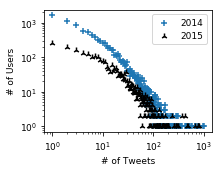

In [392]:
fig, ax = plt.subplots(figsize=(3,2.25))

vc14 = gg_df.first('2M').groupby('user.id')['user.id'].count().value_counts()
vc15 = gg15.first('2M').groupby('user.id')['user.id'].count().value_counts()
plt.scatter(vc14.index, vc14.values, label='2014', marker='+')
plt.scatter(vc15.index, vc15.values, c='k', label='2015', marker='2')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('# of Tweets')
plt.ylabel('# of Users')
plt.savefig('figs/evolution/scatter-observed-all.pdf', bbox_inches='tight')
xlim, ylim = plt.xlim(), plt.ylim()
plt.show()

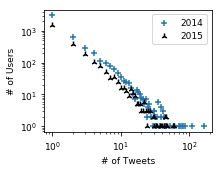

In [393]:
fig, ax = plt.subplots(figsize=(3,2.25))

vc14 = hashtag_df(gg_df.first('2M'), 'gamergate').groupby('user.id')['user.id'].count().value_counts()
vc15 = hashtag_df(gg15.first('2M'), 'gamergate').groupby('user.id')['user.id'].count().value_counts()
plt.scatter(vc14.index, vc14.values, label='2014', marker='+')
plt.scatter(vc15.index, vc15.values, c='k', label='2015', marker='2')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('# of Tweets')
plt.ylabel('# of Users')
plt.savefig('figs/evolution/scatter-observed-all.pdf', bbox_inches='tight')
xlim, ylim = plt.xlim(), plt.ylim()
plt.show()

**RQ:** Which variables are correlated with continued activity?

**(EV1) High-Activity Users**

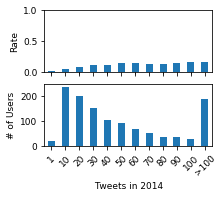

In [399]:
tweet_counts = pd.concat([gg_df.groupby('user.id')['user.id'].count(), gg15.groupby('user.id')['user.id'].count()], axis=1).fillna(0)
tweet_counts.columns = ["tweets.2014", "tweets.2015"]
tweet_counts['tweet_group.2014'] = pd.cut(tweet_counts['tweets.2014'], [0, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 500])
tweet_counts[tweet_counts['tweet_group.2014'] == '(100, 500]']['tweet_group.2014'] = '>100'

fig, (ax, ax2) = plt.subplots(2,1, figsize=(3,2.5))
conversion_rates = tweet_counts[~tweet_counts['tweet_group.2014'].isnull()].groupby('tweet_group.2014').apply(lambda df: np.count_nonzero(df['tweets.2015']) / len(df['tweets.2015'])).plot(kind='bar', ax=ax, sharex=True)
conversions = tweet_counts[~tweet_counts['tweet_group.2014'].isnull()].groupby('tweet_group.2014').apply(lambda df: np.count_nonzero(df['tweets.2015'])).plot(kind='bar', ax=ax2)
ax.set_ylim(0, 1)
ax.set_ylabel("Rate")
ax2.set_xlabel("Tweets in 2014")
ax2.set_xticklabels([i.right for idx, i in enumerate(tweet_counts['tweet_group.2014'].cat.categories) if idx < len(tweet_counts['tweet_group.2014'].cat.categories) - 1] + ['>100'])
ax2.xaxis.set_tick_params(rotation=45)
ax2.set_ylabel('# of Users')
plt.savefig("figs/evolution/conversion_all.pdf", bbox_inches='tight')
plt.show()

In [492]:
def ehyp1(threshold):
    tweet_counts = pd.concat([gg_df.groupby('user.id')['user.id'].count(), gg15.groupby('user.id')['user.id'].count()], axis=1).fillna(0)
    tweet_counts.columns = ["tweets.2014", "tweets.2015"]
    tw = tweet_counts
    
    above = tw[tw['tweets.2014'] >= threshold]
    below = tw[tw['tweets.2014'] < threshold]
    above_remained = above['tweets.2015'].fillna(0) > 0
    below_remained = below['tweets.2015'].fillna(0) > 0
    
    #print(above_remained.value_counts(), above_remained.value_counts()[[1,0]], above_remained.value_counts().loc[[1,0]])

    contingency = np.vstack([above_remained.value_counts().loc[[1,0]], below_remained.value_counts().loc[[1,0]]])
    chi2, p, dof, exp = stats.chi2_contingency(contingency)
    return {
        'freq_ratio': (above_remained.value_counts().loc[True] / above_remained.value_counts().values.sum()) / (below_remained.value_counts().loc[True] / below_remained.value_counts().values.sum()),
        'effect_size': {'phi': phi_coeff(contingency)},
        'kind': 'chi2',
        'stat': {'statistic': chi2, 'pvalue': p, 'dof': dof},
        'table': contingency
    }
ehyp1(10)

{'effect_size': {'phi': -0.12852029349570318},
 'freq_ratio': 0.5486890916920488,
 'kind': 'chi2',
 'stat': {'dof': 1,
  'pvalue': 1.2209641526206987e-60,
  'statistic': 269.85412128771316},
 'table': array([[ 979, 7566],
        [1636, 6199]])}

**(EV2) High-Hashtag-Activity Users**

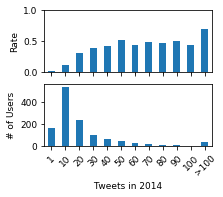

In [400]:
tweet_counts = pd.concat([hashtag_df(gg_df, 'gamergate').groupby('user.id')['user.id'].count(), hashtag_df(gg15, 'gamergate').groupby('user.id')['user.id'].count()], axis=1).fillna(0)
tweet_counts.columns = ["tweets.2014", "tweets.2015"]
tweet_counts['tweet_group.2014'] = pd.cut(tweet_counts['tweets.2014'], [0, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 500])
tweet_counts[tweet_counts['tweet_group.2014'] == '(100, 500]']['tweet_group.2014'] = '>100'

fig, (ax, ax2) = plt.subplots(2,1, figsize=(3,2.5))
conversion_rates = tweet_counts[~tweet_counts['tweet_group.2014'].isnull()].groupby('tweet_group.2014').apply(lambda df: np.count_nonzero(df['tweets.2015']) / len(df['tweets.2015'])).plot(kind='bar', ax=ax, sharex=True)
conversions = tweet_counts[~tweet_counts['tweet_group.2014'].isnull()].groupby('tweet_group.2014').apply(lambda df: np.count_nonzero(df['tweets.2015'])).plot(kind='bar', ax=ax2)
ax.set_ylim(0, 1)
ax.set_ylabel("Rate")
ax2.set_xlabel("Tweets in 2014")
ax2.set_xticklabels([i.right for idx, i in enumerate(tweet_counts['tweet_group.2014'].cat.categories) if idx < len(tweet_counts['tweet_group.2014'].cat.categories) - 1] + ['>100'])
ax2.xaxis.set_tick_params(rotation=45)
ax2.set_ylabel('# of Users')
plt.savefig("figs/evolution/conversion.pdf", bbox_inches='tight')
plt.show()

In [494]:
def ehyp2(threshold):
    tweet_counts = pd.concat([hashtag_df(gg_df, 'gamergate').groupby('user.id')['user.id'].count(), hashtag_df(gg15, 'gamergate').groupby('user.id')['user.id'].count()], axis=1).fillna(0)
    tweet_counts.columns = ["tweets.2014", "tweets.2015"]
    tw = tweet_counts
    
    above = tw[tw['tweets.2014'] >= threshold]
    below = tw[tw['tweets.2014'] < threshold]
    above_remained = above['tweets.2015'].fillna(0) > 0
    below_remained = below['tweets.2015'].fillna(0) > 0
    
    #print(above_remained.value_counts(), above_remained.value_counts()[[1,0]], above_remained.value_counts().loc[[1,0]])

    contingency = np.vstack([above_remained.value_counts().loc[[1,0]], below_remained.value_counts().loc[[1,0]]])
    chi2, p, dof, exp = stats.chi2_contingency(contingency)
    return {
        'freq_ratio': (above_remained.value_counts().loc[True] / above_remained.value_counts().values.sum()) / (below_remained.value_counts().loc[True] / below_remained.value_counts().values.sum()),
        'effect_size': {'phi': phi_coeff(contingency)},
        'kind': 'chi2',
        'stat': {'statistic': chi2, 'pvalue': p, 'dof': dof},
        'table': contingency
    }
ehyp2(10)

{'effect_size': {'phi': 0.17954740697380545},
 'freq_ratio': 2.624738546173462,
 'kind': 'chi2',
 'stat': {'dof': 1,
  'pvalue': 1.7390909043229284e-116,
  'statistic': 526.371644624066},
 'table': array([[  562,   985],
        [ 2053, 12780]])}

**Chatzakou Comparisons**

**(EV3) GG v GG, more tweets**

In [425]:
def ehyp3(gg_df, other_df, alt='greater'):
    gg_counts = gg_df.groupby('user.id')['user.statuses_count'].apply(lambda ser: ser.iloc[0])
    other_counts = other_df.groupby('user.id')['user.statuses_count'].apply(lambda ser: ser.iloc[0])
    stat = stats.mannwhitneyu(gg_counts, other_counts, alternative=alt)
    es = effect_size(gg_counts, other_counts, alt)
    return {
        'kind': 'mwu',
        'stat': {'pvalue': stat.pvalue, 'statistic': stat.statistic},
        'effect_size': {'c': es.cles, 'r': es.rbc},
    }
ehyp3(gg15, gg_df, alt='greater')

{'effect_size': {'c': 0.684729179576124, 'r': 0.36970629729710414},
 'kind': 'mwu',
 'stat': {'pvalue': 7.706966602847816e-201, 'statistic': 26834710.5}}

**(EV4) GG v GG, more followers**

In [419]:
def ehyp4(gg_df, other_df, alt='greater'):
    gg_counts = gg_df.groupby('user.id')['user.followers_count'].apply(lambda ser: ser.iloc[0])
    other_counts = other_df.groupby('user.id')['user.followers_count'].apply(lambda ser: ser.iloc[0])
    stat = stats.mannwhitneyu(gg_counts, other_counts, alternative=alt)
    es = effect_size(gg_counts, other_counts, alt)
    return {
        'kind': 'mwu',
        'stat': {'pvalue': stat.pvalue, 'statistic': stat.statistic},
        'effect_size': {'c': es.cles, 'r': es.rbc},
    }
ehyp4(gg15, gg_df, alt='greater')

{'effect_size': {'c': 0.7132294077353639, 'r': 0.4293754510866403},
 'kind': 'mwu',
 'stat': {'pvalue': 4.282549686191121e-270, 'statistic': 28003723.5}}

**(EV5) GG v GG, more friends**

In [420]:
def ehyp5(gg_df, other_df, alt='greater'):
    gg_counts = gg_df.groupby('user.id')['user.friends_count'].apply(lambda ser: ser.iloc[0])
    other_counts = other_df.groupby('user.id')['user.friends_count'].apply(lambda ser: ser.iloc[0])
    stat = stats.mannwhitneyu(gg_counts, other_counts, alternative=alt)
    es = effect_size(gg_counts, other_counts, alt)
    return {
        'kind': 'mwu',
        'stat': {'pvalue': stat.pvalue, 'statistic': stat.statistic},
        'effect_size': {'c': es.cles, 'r': es.rbc},
    }
ehyp5(gg15, gg_df, alt='greater')

{'effect_size': {'c': 0.7006036521811921, 'r': 0.4025655664321101},
 'kind': 'mwu',
 'stat': {'pvalue': 1.1063687865080504e-237, 'statistic': 27478475.5}}

In [421]:
rand15 = read_df(['random-fall-2015.json']) # todo: issue with filter_spam here, possibly due to different collection method? 

**(EV3,4,5-r) GG v rand, more friends, more followers, more tweets**

In [426]:
print(ehyp3(gg15, rand15, alt='greater'))
print(ehyp4(gg15, rand15, alt='greater'))
print(ehyp5(gg15, rand15, alt='greater'))

{'kind': 'mwu', 'effect_size': {'r': -0.1591057984365214, 'c': 0.4204088480966619}, 'stat': {'pvalue': 1.0, 'statistic': 210807820.5}}
{'kind': 'mwu', 'effect_size': {'r': -0.03420824371241499, 'c': 0.48224000998504873}, 'stat': {'pvalue': 0.9986913630833969, 'statistic': 242118990.5}}
{'kind': 'mwu', 'effect_size': {'r': 0.10358547695560677, 'c': 0.5512682890695547}, 'stat': {'pvalue': 4.0124238346012434e-20, 'statistic': 276663162.5}}


**Community Engagement**

**(EV6) Evolution Hypothesis 6:** GG users that remained active were mentioned more than those that dropped out.

In [474]:
def ehyp6(late_df, early_df, alt='greater', early_mdf=None):
    if early_mdf is None:
        early_mdf = c.mdf(early_df)
    dropouts = [uid for uid in early_df['user.id'].unique()
                if uid not in late_df['user.id'].values]
    remainers = [uid for uid in early_df['user.id'].unique()
                 if uid in late_df['user.id'].values]
    
    m = early_mdf.groupby('mention.id').count()
    dropout_counts = m.loc[dropouts].fillna(0)['user.id'].values.squeeze()
    remain_counts = m.loc[remainers].fillna(0)['user.id'].values.squeeze()
    stat = stats.mannwhitneyu(remain_counts, dropout_counts, alternative=alt)
    es = effect_size(remain_counts, dropout_counts, alt)
    return {
        'kind': 'mwu',
        'stat': {'pvalue': stat.pvalue, 'statistic': stat.statistic},
        'effect_size': {'c': es.cles, 'r': es.rbc},
        'mean_ratio': remain_counts.mean() / dropout_counts.mean()
    }
ehyp6(gg15, gg_df, early_mdf=gg_mdf)

{'effect_size': {'c': 0.6924783076527449, 'r': 0.47737848516064363},
 'kind': 'mwu',
 'mean_ratio': 4.0261017824461245,
 'stat': {'pvalue': 2.712754325507856e-185, 'statistic': 12394862.0}}

**(EV6b)** GG users that were mentioned at least once remained active more frequently.

In [502]:
def ehyp6b(late_df, early_df, alt='greater', early_mdf=None):
    if early_mdf is None:
        early_mdf = c.mdf(early_df)
    dropouts = [uid for uid in early_df['user.id'].unique()
                if uid not in late_df['user.id'].values]
    remainers = [uid for uid in early_df['user.id'].unique()
                 if uid in late_df['user.id'].values]
    
    m = early_mdf.groupby('mention.id').count()
    dropout_counts = m.loc[dropouts].fillna(0)['user.id']
    remain_counts = m.loc[remainers].fillna(0)['user.id']
    
    contingency = np.vstack([
        (remain_counts > 0).value_counts().loc[[1,0]],
        (dropout_counts > 0).value_counts().loc[[1,0]]
    ])

    chi2, p, dof, exp = stats.chi2_contingency(contingency)
    return {
        'freq_ratio': (contingency[0, 0] / contingency[0, :].sum()) / (contingency[1,0] / contingency[1,:].sum()),
        'effect_size': {'phi': phi_coeff(contingency)},
        'kind': 'chi2',
        'stat': {'statistic': chi2, 'pvalue': p, 'dof': dof},
        'table': contingency
    }
ehyp6b(gg15, gg_df, early_mdf=gg_mdf)

{'effect_size': {'phi': 0.1804784508977049},
 'freq_ratio': 1.6197919804423555,
 'kind': 'chi2',
 'stat': {'dof': 1,
  'pvalue': 7.304093887476435e-108,
  'statistic': 486.7381130716289},
 'table': array([[1045,  174],
        [7285, 6480]])}

**(EV7) Evolution Hypothesis 7:** GG users that remained active were retweeted more than those that dropped out.

In [446]:
def ehyp7(late_df, early_df, alt='greater'):
    early_rdf = early_df[['user.id', 'retweeted_status.user.id']]
    dropouts = [uid for uid in early_df['user.id'].unique()
                if uid not in late_df['user.id'].values]
    remainers = [uid for uid in early_df['user.id'].unique()
                 if uid in late_df['user.id'].values]
    
    m = early_rdf.groupby('retweeted_status.user.id').count()
    dropout_counts = m.loc[dropouts].fillna(0).values.squeeze()
    remain_counts = m.loc[remainers].fillna(0).values.squeeze()
    stat = stats.mannwhitneyu(remain_counts, dropout_counts, alternative=alt)
    es = effect_size(remain_counts, dropout_counts, alt)
    return {
        'kind': 'mwu',
        'stat': {'pvalue': stat.pvalue, 'statistic': stat.statistic},
        'effect_size': {'c': es.cles, 'r': es.rbc},
        'mean_ratio': remain_counts.mean() / dropout_counts.mean()
    }
ehyp7(gg15, gg_df)

{'effect_size': {'c': 0.6318495715167315, 'r': 0.45108460991320676},
 'kind': 'mwu',
 'mean_ratio': 4.583797908349811,
 'stat': {'pvalue': 2.420365501094447e-191, 'statistic': 12174262.5}}

In [501]:
def ehyp7b(late_df, early_df):
    early_rdf = early_df[['user.id', 'retweeted_status.user.id']]
    dropouts = [uid for uid in early_df['user.id'].unique()
                if uid not in late_df['user.id'].values]
    remainers = [uid for uid in early_df['user.id'].unique()
                 if uid in late_df['user.id'].values]
    
    m = early_rdf.groupby('retweeted_status.user.id').count()
    dropout_counts = m.loc[dropouts].fillna(0)['user.id']
    remain_counts = m.loc[remainers].fillna(0)['user.id']
    
    contingency = np.vstack([
        (remain_counts > 0).value_counts().loc[[1,0]],
        (dropout_counts > 0).value_counts().loc[[1,0]]
    ])

    chi2, p, dof, exp = stats.chi2_contingency(contingency)
    return {
        'freq_ratio': (contingency[0, 0] / contingency[0, :].sum()) / (contingency[1,0] / contingency[1,:].sum()),
        'effect_size': {'phi': phi_coeff(contingency)},
        'kind': 'chi2',
        'stat': {'statistic': chi2, 'pvalue': p, 'dof': dof},
        'table': contingency
    }
ehyp7b(gg15, gg_df)

{'effect_size': {'phi': 0.20638171252673132},
 'freq_ratio': 1.98974863834427,
 'kind': 'chi2',
 'stat': {'dof': 1,
  'pvalue': 1.7598254985707855e-140,
  'statistic': 636.682414012238},
 'table': array([[ 908,  311],
        [5153, 8612]])}

**(EV8) Evolution Hypothesis 8:** {Pro,Anti}-GG group membership has a significant relationship with active status.

In [500]:
def ehyp8(late_df, pro_group, anti_group, non_group):
    groups = {
        'Any Notable': np.hstack([pro_group, anti_group]),
        'Any Pro': pro_group,
        'Any Anti': anti_group,
        'No Notable': non_group,
        'No Pro': np.hstack([anti_group, non_group]),
        'No Anti': np.hstack([pro_group, non_group]),
    }
    
    rows = [
        ('Any Notable', 'No Notable'),
        ('Any Pro', 'No Notable'),
        ('Any Anti', 'No Notable'),
        ('Any Pro', 'No Pro'),
        ('Any Anti', 'No Anti'),
    ]
    
    lc = late_df.groupby('user.id')['id'].count()
    tests = []
    for label, label2 in rows:
        group = groups[label]
        group2 = groups[label2]
        contingency = np.vstack([
            (lc.loc[group].fillna(0) > 0).value_counts().loc[[1,0]],
            (lc.loc[group2].fillna(0) > 0).value_counts().loc[[1,0]]
        ])

        chi2, p, dof, exp = stats.chi2_contingency(contingency)

        tests.append({
            'group1': label,
            'group2': label2,
            'test': {
                'freq_ratio': (contingency[0, 0] / contingency[0, :].sum()) / (contingency[1,0] / contingency[1,:].sum()),
                'effect_size': {'phi': phi_coeff(contingency)},
                'kind': 'chi2',
                'stat': {'statistic': chi2, 'pvalue': p, 'dof': dof},
                'table': contingency
            }
        })
    return pd.io.json.json_normalize(tests)
print(ehyp8(gg15, pro_group, anti_group, non_group).set_index(['group1', 'group2'])[['test.stat.pvalue', 'test.stat.statistic', 'test.effect_size.phi', 'test.freq_ratio']].to_latex())

\begin{tabular}{llrrrr}
\toprule
         &         &  test.stat.pvalue &  test.stat.statistic &  test.effect\_size.phi &  test.freq\_ratio \\
group1 & group2 &                   &                      &                       &                  \\
\midrule
Any Notable & No Notable &     7.607749e-134 &           606.172437 &              0.201149 &         3.633377 \\
Any Pro &         &     8.091480e-206 &           937.186841 &              0.261663 &         4.795127 \\
Any Anti &         &      4.513373e-02 &             4.013636 &             -0.019130 &         0.724985 \\
Any Pro & No Pro &     1.358411e-225 &          1028.161610 &              0.261921 &         4.945542 \\
Any Anti & No Anti &      2.353766e-11 &            44.651838 &             -0.054953 &         0.381385 \\
\bottomrule
\end{tabular}



## Newly-Active Users

In [508]:
print(gg15[~gg15['user.id'].isin(gg_df['user.id'])]['user.id'].nunique(), gg15['user.id'].nunique())

1396 2615


In [26]:
rem_active = gg15[gg15['user.id'].isin(gg_df['user.id'])]['user.id'].unique()
newly_active = gg15[~gg15['user.id'].isin(gg_df['user.id'])]['user.id'].unique()

In [30]:
na_creations = gg15.groupby('user.id')['user.created_at'].agg(lambda ser: ser[0]).loc[newly_active]
np.count_nonzero(pd.to_datetime(na_creations) < pd.to_datetime('28 August 2014'))
new_acct_active = na_creations[pd.to_datetime(na_creations) < pd.to_datetime('28 August 2014')].index

In [552]:
prior_to = pd.to_datetime('aug 28 2014')
print(np.count_nonzero(creation_times.loc[newly_active] < prior_to) / len(newly_active))
print(np.count_nonzero(creation_times.loc[rem_active] < prior_to) / len(rem_active))
print(np.count_nonzero(pd.to_datetime(gg_df.groupby('user.id')['user.created_at'].apply(lambda s: s.iloc[0])) < prior_to) / len(gg_df['user.id'].unique()))

0.5415472779369628
0.7350287120590648
0.8232781633742658


(732549.1319936343, 736028.208365162)


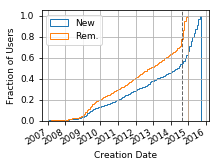

In [542]:
creation_times = pd.to_datetime(gg15.groupby('user.id')['user.created_at'].apply(lambda ser: ser.iloc[0]))
fig, ax = plt.subplots(figsize=(3,2.25))
creation_times.loc[newly_active].hist(histtype='step', normed=True, bins=100, label='New', cumulative=True, ax=ax)
creation_times.loc[rem_active].hist(histtype='step', normed=True, bins=100, label='Rem.', cumulative=True, ax=ax)
fig.autofmt_xdate()
plt.xlabel('Creation Date')
plt.ylabel('Fraction of Users')
plt.legend(loc='upper left')
#ax.grid('off')
plt.axvline(pd.to_datetime('28 August 2014'), ls='--', c='k', lw='1', alpha=0.6)
plt.savefig('figs/evolution/creation_date_cdf.pdf', bbox_inches='tight')
print(plt.xlim())
plt.show()

0.5843728813559321


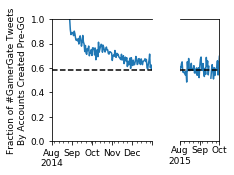

In [559]:
prior_to = pd.to_datetime('aug 28 2014')
td14 = hashtag_df(gg_df, 'gamergate').groupby(pd.TimeGrouper('1D'))['user.created_at'].apply(lambda ser: np.count_nonzero(pd.to_datetime(ser) < prior_to) / len(ser))
td15 = hashtag_df(gg15, 'gamergate').groupby(pd.TimeGrouper('1D'))['user.created_at'].apply(lambda ser: (np.count_nonzero(pd.to_datetime(ser) < prior_to) / len(ser)) if len(ser) > 0 else np.nan)
import matplotlib.dates as dates
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw = {'width_ratios': [5, 2]}, figsize=(3,2.25))
td14.plot(ylim=[0,1], ax=ax1, sharey=True)
td15.plot(ylim=[0,1], ax=ax2, sharey=True)
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.yaxis.set_visible(False)
ax2.xaxis.set_minor_locator(dates.WeekdayLocator())
ax2.get_xaxis().set_tick_params(direction='out', pad=-19.5)
ax2.set_xlabel('')
ax1.set_xlabel('')
ax1.set_xlim([pd.to_datetime('1 aug 2014'), pd.to_datetime('31 dec 2014')])
ax1.set_ylim([0,1.0])
ax2.set_ylim([0, 1.0])
ax1.set_ylabel('Fraction of #GamerGate Tweets\nBy Accounts Created Pre-GG')
ax1.axhline(td15.median(), c='k', lw=1.5, ls='--')
ax2.axhline(td15.median(), c='k', lw=1.5, ls='--')
print(td15.median())
plt.subplots_adjust(wspace=0.4)
plt.savefig('figs/evolution/active_pre-gg_by-day.pdf', bbox_inches='tight')
plt.show()

**(NA1) Newly-Active Hypothesis 1:** Newly-active users retweet others less than remaining users.

In [34]:
def nhyp1(late_df, new, rem, alt='less'):
    rdf = late_df[['user.id', 'retweeted_status.user.id']]
    
    m = rdf.groupby('user.id').count()
    new_counts = m.loc[new].fillna(0)['retweeted_status.user.id']
    remain_counts = m.loc[rem].fillna(0)['retweeted_status.user.id']
    
    stat = stats.mannwhitneyu(new_counts, remain_counts, alternative=alt)
    es = effect_size(new_counts, remain_counts, alt)
    return {
        'kind': 'mwu',
        'stat': {'pvalue': stat.pvalue, 'statistic': stat.statistic},
        'effect_size': {'c': es.cles, 'r': es.rbc},
        'mean_ratio': new_counts.mean() / remain_counts.mean(),
        'means': { 'left': new_counts.mean(), 'right': remain_counts.mean() }
    }
nhyp1(gg15, newly_active, rem_active)

{'effect_size': {'c': 0.5584471982530658, 'r': 0.1843171983235825},
 'kind': 'mwu',
 'mean_ratio': 0.804208511485015,
 'means': {'left': 9.851719197707736, 'right': 12.250205086136177},
 'stat': {'pvalue': 1.474808230744915e-16, 'statistic': 694033.5}}

In [35]:
nhyp1(gg15, new_acct_active, rem_active)

{'effect_size': {'c': 0.5640921303349523, 'r': 0.19830310211770424},
 'kind': 'mwu',
 'mean_ratio': 0.7313342630593016,
 'means': {'left': 8.958994708994709, 'right': 12.250205086136177},
 'stat': {'pvalue': 4.806304409747276e-14, 'statistic': 369407.5}}

In [45]:
nhyp1(gg15, new_acct_active, [u for u in newly_active if u not in new_acct_active])

{'effect_size': {'c': 0.4656932043650794, 'r': 0.016271908068783092},
 'kind': 'mwu',
 'mean_ratio': 0.8214551022573945,
 'means': {'left': 8.958994708994709, 'right': 10.90625},
 'stat': {'pvalue': 0.29888709326535295, 'statistic': 237983.5}}

**(NA2) Newly-Active Hypothesis 2:** Newly-active users mentioned other users less.

In [38]:
def nhyp2(late_df, new, rem, alt='less'):
    mdf = c.mdf(late_df)
    
    m = mdf.groupby('user.id').count()
    new_counts = m.loc[new].fillna(0)['mention.id']
    remain_counts = m.loc[rem].fillna(0)['mention.id']
    
    stat = stats.mannwhitneyu(new_counts, remain_counts, alternative=alt)
    es = effect_size(new_counts, remain_counts, alt)
    return {
        'kind': 'mwu',
        'stat': {'pvalue': stat.pvalue, 'statistic': stat.statistic},
        'effect_size': {'c': es.cles, 'r': es.rbc},
        'mean_ratio': new_counts.mean() / remain_counts.mean(),
        'means': { 'left': new_counts.mean(), 'right': remain_counts.mean() }
    }
nhyp2(gg15, newly_active, rem_active)

{'effect_size': {'c': 0.5226311669812496, 'r': 0.1287752890598005},
 'kind': 'mwu',
 'mean_ratio': 0.7717186937828343,
 'means': {'left': 11.590974212034384, 'right': 15.019688269073011},
 'stat': {'pvalue': 4.840591975633899e-09, 'statistic': 741292.0}}

In [42]:
nhyp2(gg15, new_acct_active, rem_active)

{'effect_size': {'c': 0.5274175206496782, 'r': 0.13972116966374554},
 'kind': 'mwu',
 'mean_ratio': 0.7462867742784723,
 'means': {'left': 11.208994708994709, 'right': 15.019688269073011},
 'stat': {'pvalue': 6.98584875466767e-08, 'statistic': 396401.0}}

In [46]:
nhyp2(gg15, new_acct_active, [u for u in newly_active if u not in new_acct_active])

{'effect_size': {'c': 0.46025132275132274, 'r': 0.024696180555555558},
 'kind': 'mwu',
 'mean_ratio': 0.9308105117109917,
 'means': {'left': 11.208994708994709, 'right': 12.0421875},
 'stat': {'pvalue': 0.21023409106905167, 'statistic': 235945.5}}

**(NA3)** Newly-active users retweet GG users at a different rate than remaining users.

In [55]:
def nhyp3(late_df, new, rem, group):
    rdf = late_df[['user.id', 'retweeted_status.user.id']]
    
    m_in = rdf.groupby('user.id')['retweeted_status.user.id'].agg(lambda ser: np.count_nonzero(ser.isin(group)))
    m_out = rdf.groupby('user.id')['retweeted_status.user.id'].agg(lambda ser: np.count_nonzero(~ser.isin(group)))
    
    contingency = np.array([
        [m_in.loc[new].fillna(0).sum(), m_out.loc[new].fillna(0).sum()],
        [m_in.loc[rem].fillna(0).sum(), m_out.loc[rem].fillna(0).sum()],
    ])

    chi2, p, dof, exp = stats.chi2_contingency(contingency)
    return {
        'freq_ratio': (contingency[0, 0] / contingency[0, :].sum()) / (contingency[1,0] / contingency[1,:].sum()),
        'freqs': {'top': contingency[0, 0] / contingency[0, :].sum(), 'bottom': contingency[1,0] / contingency[1,:].sum()},
        'effect_size': {'phi': phi_coeff(contingency)},
        'kind': 'chi2',
        'stat': {'statistic': chi2, 'pvalue': p, 'dof': dof},
        'table': contingency
    }
nhyp3(gg15, newly_active, rem_active, gg15['user.id'].unique())

{'effect_size': {'phi': -0.17969387686051025},
 'freq_ratio': 0.4418487401381558,
 'freqs': {'bottom': 0.24286259409581296, 'top': 0.10730853122791927},
 'kind': 'chi2',
 'stat': {'dof': 1, 'pvalue': 0.0, 'statistic': 1980.932598364096},
 'table': array([[ 3493., 29058.],
        [ 7001., 21826.]])}

In [58]:
nhyp3(gg15, new_acct_active, rem_active, gg15['user.id'].unique())

{'effect_size': {'phi': -0.17940900325982367},
 'freq_ratio': 0.40079804431081106,
 'freqs': {'bottom': 0.24286259409581296, 'top': 0.09733885274985216},
 'kind': 'chi2',
 'stat': {'dof': 1, 'pvalue': 0.0, 'statistic': 1471.2148010873773},
 'table': array([[ 1646., 15264.],
        [ 7001., 21826.]])}

In [60]:
nhyp3(gg15, new_acct_active, [u for u in newly_active if u not in new_acct_active], gg15['user.id'].unique())

{'effect_size': {'phi': -0.03349290987922734},
 'freq_ratio': 0.8242972365243301,
 'freqs': {'bottom': 0.11808707883127677, 'top': 0.09733885274985216},
 'kind': 'chi2',
 'stat': {'dof': 1,
  'pvalue': 1.6928315416326935e-09,
  'statistic': 36.29862615152178},
 'table': array([[ 1646., 15264.],
        [ 1847., 13794.]])}

**(NA3b)** NA users retweet GG users significantly less than remaining users.

In [56]:
def nhyp3b(late_df, new, rem, group, alt='less'):
    rdf = late_df[['user.id', 'retweeted_status.user.id']]
    m = rdf.groupby('user.id')['retweeted_status.user.id'].agg(lambda ser: np.count_nonzero(ser.isin(group)))
    
    new_counts = m.loc[new].fillna(0)
    remain_counts = m.loc[rem].fillna(0)
    
    stat = stats.mannwhitneyu(new_counts, remain_counts, alternative=alt)
    es = effect_size(new_counts, remain_counts, alt)
    return {
        'kind': 'mwu',
        'stat': {'pvalue': stat.pvalue, 'statistic': stat.statistic},
        'effect_size': {'c': es.cles, 'r': es.rbc},
        'mean_ratio': new_counts.mean() / remain_counts.mean(),
        'means': { 'left': new_counts.mean(), 'right': remain_counts.mean() }
    }
nhyp3b(gg15, newly_active, rem_active, gg15['user.id'].unique())

{'effect_size': {'c': 0.5974076877331459, 'r': 0.342413928463135},
 'kind': 'mwu',
 'mean_ratio': 0.43566913691003617,
 'means': {'left': 2.5021489971346704, 'right': 5.743232157506153},
 'stat': {'pvalue': 6.172298090197302e-54, 'statistic': 559515.0}}

In [61]:
nhyp3b(gg15, new_acct_active, rem_active, gg15['user.id'].unique())

{'effect_size': {'c': 0.6169283956404547, 'r': 0.3901139801467939},
 'kind': 'mwu',
 'mean_ratio': 0.3790981484882356,
 'means': {'left': 2.177248677248677, 'right': 5.743232157506153},
 'stat': {'pvalue': 3.37334006242465e-50, 'statistic': 281024.5}}

In [62]:
nhyp3b(gg15, new_acct_active, [u for u in newly_active if u not in new_acct_active], gg15['user.id'].unique())

{'effect_size': {'c': 0.43433986441798944, 'r': 0.09049892526455028},
 'kind': 'mwu',
 'mean_ratio': 0.754433759306526,
 'means': {'left': 2.177248677248677, 'right': 2.8859375},
 'stat': {'pvalue': 0.0012572406466560926, 'statistic': 220026.5}}

**(NA4)** Newly-active users mention other GG users at a significantly different rate.

In [63]:
def nhyp4(late_df, new, rem, group):
    mdf = c.mdf(late_df)
    
    m_in = mdf.groupby('user.id')['mention.id'].agg(lambda ser: np.count_nonzero(ser.isin(group)))
    m_out = mdf.groupby('user.id')['mention.id'].agg(lambda ser: np.count_nonzero(~ser.isin(group)))
    
    contingency = np.array([
        [m_in.loc[new].fillna(0).sum(), m_out.loc[new].fillna(0).sum()],
        [m_in.loc[rem].fillna(0).sum(), m_out.loc[rem].fillna(0).sum()],
    ])

    chi2, p, dof, exp = stats.chi2_contingency(contingency)
    return {
        'freq_ratio': (contingency[0, 0] / contingency[0, :].sum()) / (contingency[1,0] / contingency[1,:].sum()),
        'freqs': {'top': contingency[0, 0] / contingency[0, :].sum(), 'bottom': contingency[1,0] / contingency[1,:].sum()},
        'effect_size': {'phi': phi_coeff(contingency)},
        'kind': 'chi2',
        'stat': {'statistic': chi2, 'pvalue': p, 'dof': dof},
        'table': contingency
    }
nhyp4(gg15, newly_active, rem_active, gg15['user.id'].unique())

{'effect_size': {'phi': -0.12639002004412955},
 'freq_ratio': 0.7230916733190917,
 'freqs': {'bottom': 0.44562783330602435, 'top': 0.3222297756628144},
 'kind': 'chi2',
 'stat': {'dof': 1,
  'pvalue': 1.0105621570112092e-121,
  'statistic': 550.4386636253619},
 'table': array([[ 5214., 10967.],
        [ 8159., 10150.]])}

In [64]:
def nhyp4b(late_df, new, rem, group, alt='less'):
    mdf = c.mdf(late_df)
    m = mdf.groupby('user.id')['mention.id'].agg(lambda ser: np.count_nonzero(ser.isin(group)))
    
    new_counts = m.loc[new].fillna(0)
    remain_counts = m.loc[rem].fillna(0)
    
    stat = stats.mannwhitneyu(new_counts, remain_counts, alternative=alt)
    es = effect_size(new_counts, remain_counts, alt)
    return {
        'kind': 'mwu',
        'stat': {'pvalue': stat.pvalue, 'statistic': stat.statistic},
        'effect_size': {'c': es.cles, 'r': es.rbc},
        'mean_ratio': new_counts.mean() / remain_counts.mean(),
        'means': { 'left': new_counts.mean(), 'right': remain_counts.mean() }
    }
nhyp4b(gg15, newly_active, rem_active, gg15['user.id'].unique())

{'effect_size': {'c': 0.5164550773215868, 'r': 0.2455086723816553},
 'kind': 'mwu',
 'mean_ratio': 0.5580233616190534,
 'means': {'left': 3.7349570200573066, 'right': 6.693191140278917},
 'stat': {'pvalue': 2.1699219514851408e-30, 'statistic': 641968.0}}

**(NA5)** Newly-active users retweet notables less than remaining users.

In [68]:
def nhyp5(late_df, notables, new, rem, alt='less'):
    late_rdf = late_df[['user.id', 'retweeted_status.user.id']]
    
    m = late_rdf.groupby('user.id')['retweeted_status.user.id'].agg(lambda ser: ser.value_counts().loc[notables].fillna(0).sum())
    new_counts = m.loc[new].fillna(0).values.squeeze()
    remain_counts = m.loc[rem].fillna(0).values.squeeze()
    
    stat = stats.mannwhitneyu(new_counts, remain_counts, alternative=alt)
    es = effect_size(new_counts, remain_counts, alt)
    return {
        'kind': 'mwu',
        'stat': {'pvalue': stat.pvalue, 'statistic': stat.statistic},
        'effect_size': {'c': es.cles, 'r': es.rbc},
        'mean_ratio': new_counts.mean() / remain_counts.mean(),
        'means': { 'left': new_counts.mean(), 'right': remain_counts.mean() }
    }
nhyp5(gg15, notables['user.id'], newly_active, rem_active)

{'effect_size': {'c': 0.36304888454296935, 'r': 0.18563703632316403},
 'kind': 'mwu',
 'mean_ratio': 0.4754301599969232,
 'means': {'left': 0.4648997134670487, 'right': 0.977850697292863},
 'stat': {'pvalue': 1.1809322153901836e-22, 'statistic': 692910.5}}

**(NA5b)** Newly-active users retweet Pro-GG notables less than remaining users.

In [69]:
nhyp5(gg15, pro_gg, newly_active, rem_active)

{'effect_size': {'c': 0.27171092374556627, 'r': 0.13022969647251847},
 'kind': 'mwu',
 'mean_ratio': 0.5035836969262828,
 'means': {'left': 0.29083094555873923, 'right': 0.5775225594749795},
 'stat': {'pvalue': 1.1025891188454223e-14, 'statistic': 740054.5}}

**(NA6a)** IMR, entire active set 2015

In [74]:
compare_to_random(gg15)

{'effect_size': {'phi': 0.494057854205084},
 'kind': 'chi2',
 'stat': {'dof': 1, 'pvalue': 0.0, 'statistic': 20625.192993408244},
 'table': array([[ 9007., 14474.],
        [ 1343., 59687.]])}

**(NA6b)** IMR, remaining set

In [75]:
compare_to_random(gg15[~gg15['user.id'].isin(newly_active)])

{'effect_size': {'phi': 0.44874617049519483},
 'kind': 'chi2',
 'stat': {'dof': 1, 'pvalue': 0.0, 'statistic': 14849.821417224983},
 'table': array([[ 4299.,  8436.],
        [ 1343., 59687.]])}

**(NA7)** There is a significant difference in the in-mention rates of (a) remaining users, (b) all active users.

In [76]:
c.test_vs_random(gg15, c.mdf(gg15), rem_active, gg15['user.id'].unique())

{'effect_size': {'phi': -0.04530065931883241},
 'kind': 'chi2',
 'stat': {'dof': 1,
  'pvalue': 8.901165211093952e-18,
  'statistic': 73.74228171724293},
 'table': array([[ 4279.,  8363.],
        [ 8987., 14401.]])}

In [78]:
c.test_vs_random(gg15, c.mdf(gg15), [u for u in gg15['user.id'].unique() if u not in new_acct_active], gg15['user.id'].unique())

{'effect_size': {'phi': -0.024445143447796493},
 'kind': 'chi2',
 'stat': {'dof': 1,
  'pvalue': 7.319360583096776e-07,
  'statistic': 24.529162578453057},
 'table': array([[ 6426., 11405.],
        [ 8987., 14401.]])}

In [80]:
cont = c.test_vs_random(gg15, c.mdf(gg15), [u for u in gg15['user.id'].unique() if u not in new_acct_active], gg15['user.id'].unique())['table']
cont[:,0] / cont.sum(axis=1)

array([0.3603836 , 0.38425688])

**Screen Name Distance**

In [572]:
import jellyfish as jf

In [569]:
inactive_users = tweet_counts[(tweet_counts['tweets.2015'] == 0) & (tweet_counts['tweets.2014'] > 0)].index.unique()
gg14_inactive_names = gg_df[gg_df['user.id'].isin(inactive_users)]['user.screen_name'].unique()

In [574]:
count = 0
for uid, df in gg15.groupby('user.id'):
    if pd.to_datetime(df['user.created_at'].iloc[0]) < prior_to:
        continue
    for screen_name in df['user.screen_name'].unique():
        dists = {name: jf.levenshtein_distance(name.lower(), screen_name.lower()) for name in gg14_inactive_names}
        result = sorted(dists.items(), key=lambda p: p[1])
        if any(d <= 3 for name, d in result):
            print(result[:2], '=>', screen_name)
            count += 1
print(count)

[('CommanderPanic', 3), ('Commanderraf', 4)] => CommanderPaul1
[('pilky', 3), ('pilloly', 4)] => PI20XY
[('ArcaneK', 3), ('DeanW1', 3)] => Arean91
[('Pkeod', 3), ('zflop', 3)] => PFJO1
[('TheDHoS', 3), ('Helghasm', 3)] => theghast
[('Foxery2', 3), ('FoxxPlays', 4)] => Foxceras
[('notyourshieldgg', 2), ('nottheirshield', 4)] => NotYourShield
[('Zaver_88', 3), ('gomer08', 3)] => Gamer_m8
[('swabl', 3), ('smbess', 3)] => SMABSO
[('Brinstar', 3), ('Rinha', 4)] => brimshae
[('GamerGateFan', 3), ('GamerGateAlt', 3)] => GamergateFacts
[('719x', 3), ('VSODH', 4)] => 715d1
[('xeos_', 3), ('_watsu', 3)] => _WCS_
[('KagoMegan', 3), ('tamoorh', 4)] => TamOmega
[('MrOmena', 3), ('Drolra', 3)] => IroynA
[('Kuldeltac', 0), ('Kale_Ca', 5)] => Kuldeltac
[('broadcasttower2', 2), ('broadcast3r', 5)] => broadcast_tower
[('Hobsie', 3), ('Kerbs01', 4)] => jabsi1
[('TheIvyClover', 1), ('The_McJones', 7)] => TheIvyClover1
[('tan1337', 3), ('tae_117', 4)] => eat_1337
[('Xanthalt81', 2), ('CarthAnne', 4)] => Xa

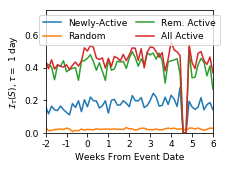

In [587]:
fig, ax = plt.subplots(figsize=(3,2.25))
imr_plot(gg15[gg15['user.id'].isin(newly_active)], ax=ax)
imr_plot(gg15[gg15['user.id'].isin(rem_active)], ax=ax, show_rand=False)
imr_plot(gg15, ax=ax, show_rand=False)
plt.legend(['Newly-Active', 'Random', 'Rem. Active', 'All Active'], ncol=2, loc='upper center', columnspacing=1)
plt.savefig('figs/evolution/imr-2015.pdf', bbox_inches='tight')
plt.show()